# Participez à la conception d'une voiture autonome

## Sommaire

* [I. Préambule](#I)
* [II. Réorganisation des données et création des masques](#II)
    * [1. Réorganisation des données](#II1)
    * [2. Création des masques](#II2)
* [III. Analyse exploratoire de données](#III)
* [IV. Modélisation des données](#IV)
    * [1. U-net](#IV1)
        * [a. Dice loss](#IV1a)
        * [b. Total loss](#IV1b)
        * [c. Balanced cross entropy](#IV1c)
    * [2. VGG-16](#IV2)
        * [a. Dice loss](#IV2a)
        * [b. Total loss](#IV2b)
        * [c. Balanced cross entropy](#IV2c)
    * [3. FCN8](#IV3)
        * [a. Dice loss](#IV3a)
        * [b. Total loss](#IV3b)
        * [c. Balanced cross entropy](#IV3c)
    * [4. Augmentation de données](#IV4)
    * [5. U-net avec données augmentées](#IV5)
        * [a. Dice loss](#IV5a)
        * [b. Total loss](#IV5b)
        * [c. Balanced cross entropy](#IV5c)
    * [6. VGG-16 avec données augmentées](#IV6)
        * [a. Dice loss](#IV6a)
        * [b. Total loss](#IV6b)
        * [c. Balanced cross entropy](#IV6c)
    * [7. Modèle FCN8 avec données augmentées](#IV7)
        * [a. Dice loss](#IV7a)
        * [b. Total loss](#IV7b)
        * [c. Balanced cross entropy](#IV7c)

## I. Préambule<a class="anchor" id="I"></a>

Future Vision Transport est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

Je suis l’un des ingénieurs IA au sein de l’équipe R&D de cette entreprise. Mon équipe est composée d’ingénieurs aux profils variés. Chacun des membres de l’équipe est spécialisé sur une des parties du système embarqué de vision par ordinateur.

Mon rôle est de concevoir un premier modèle de segmentation d’images qui devra s’intégrer facilement dans la chaîne complète du système embarqué.

In [1]:
# Import libraries
import os
from time import time
import random

# Math libraries to process the data 
import numpy as np 
import pandas as pd

# Libraries for preprocessing 
from glob import glob
import shutil
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple, Counter
from tqdm import tqdm

# Libraries for classification
import imgaug.augmenters as iaa
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import IoU
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    BatchNormalization,
    SeparableConv2D,
    UpSampling2D,
    Activation,
    Input,
    MaxPooling2D,
    Add,
    MaxPool2D,
    Dropout,
    Dense
)

## II. Réorganisation des données et création des masques<a class="anchor" id="II"></a>

### 1. Réorganisation des données<a class="anchor" id="II1"></a>

Le jeu de données est divisé en 3 parties :
* le jeu d'entraînement, constitué de 2975 images et masques annotés ;
* le jeu de validation, constitué de 500 images et masques annotés ;
* le jeu de test, constitué de 1525 images dont les annotations ne sont pas divulguées à des fins d’évaluation.

De plus, les images et masques sont contenus dans 2 dossiers :
* **leftlmg8bit**, qui contient les dossiers train, val et test des images d'origines ;
* **gtFine**, qui contient les dossiers train, val et test des images labellisées avec 30 catégories.

Nous allons corriger cette structure particulière, afin d'assurer l'intégrité des différents jeux de données, et de faciliter l'appel des images et des masques par nos modèles.

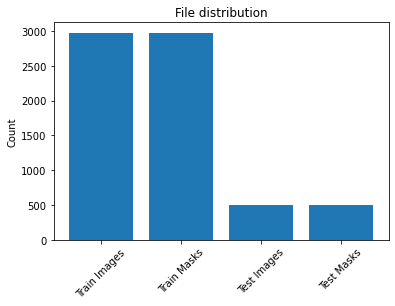

In [3]:
# Set origin folders
train_image_dir = 'data/leftImg8bit/train/*/*.png'
train_mask_dir = 'data/gtFine/train/*/*_labelIds.png'
val_image_dir = 'data/leftImg8bit/val/*/*.png'
val_mask_dir = 'data/gtFine/val/*/*_labelIds.png'

# Set final destination folders
train_input_dir = 'data/train/images'
train_masks30_dir = 'data/train/masks30'
test_input_dir = 'data/test/images'
test_masks30_dir = 'data/test/masks30'

# Function to move file from origin to destination path
def move_files(origin, destination):
    dir_exist = os.path.exists(destination)
    if not dir_exist:
      # Create a new directory because it does not exist 
      os.makedirs(destination)
    # Check if origin is directory or list
    if isinstance(origin, list):
        origin_fname = origin
    else :
        origin_fname = glob(origin)
    
    for file in origin_fname:
        shutil.move(file, destination)

move_files(train_image_dir, train_input_dir)
move_files(train_mask_dir, train_masks30_dir)
move_files(val_image_dir, test_input_dir)
move_files(val_mask_dir, test_masks30_dir)

# Create dataset
height = [
    len(os.listdir(train_input_dir)), 
    len(os.listdir(train_masks30_dir)), 
    len(os.listdir(test_input_dir)), 
    len(os.listdir(test_masks30_dir))
]
bars = ('Train Images', 'Train Masks', 'Test Images', 'Test Masks')
x_pos = np.arange(len(bars))

# Display len of differents directories
plt.figure()
plt.bar(x=x_pos, height=height)
plt.ylabel('Count')
plt.xticks(x_pos, bars, rotation=45)
plt.title('File distribution')
plt.show()

Maintenant que nos fichiers sont bien organisés, nous allons les renommer afin de retirer les mentions **gtFine_labelIds** et **leftImg8bit**. Nous allons dans le même temps créer un jeu de validation pour nos modèles.

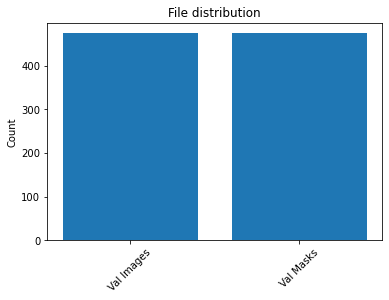

In [4]:
# Create a function to rename files
def rename_file(path, is_mask=False):
    """ Provide path of file to be renamed
    """
    # Create a list of file
    file_list = np.array(os.listdir(path))

    # Iterate over the filelist
    for filename in file_list:
        if is_mask == True:
            dest = filename.split('_gtFine_labelIds')[0] + '.png'
        else:
            dest = filename.split('_leftImg8bit')[0] + '.png'

        src = path + '/' + filename
        dest = path + '/' + dest
        os.rename(src, dest)

# Call the function
rename_file(train_input_dir, is_mask=False)
rename_file(train_masks30_dir, is_mask=True)
rename_file(test_input_dir, is_mask=False)
rename_file(test_masks30_dir, is_mask=True)

# Set validation folder
val_input_dir = 'data/val/images'
val_masks30_dir = 'data/val/masks30'

# Sort the images and masks of Train dataset
train_input_fname = sorted(
    [os.path.join(
        train_input_dir, fname) for fname in os.listdir(train_input_dir)])

train_target_fname = sorted(
    [os.path.join(
        train_masks30_dir, fname) for fname in os.listdir(train_masks30_dir)])

# Split into train and validation data
val_input_path = train_input_fname[2500:]
val_target_path = train_target_fname[2500:]

# Move files from Train to Val
move_files(val_input_path, val_input_dir)
move_files(val_target_path, val_masks30_dir)

# Create dataset
height = [
    len(os.listdir(val_input_dir)), 
    len(os.listdir(val_masks30_dir)), 
]
bars = ('Val Images', 'Val Masks')
x_pos = np.arange(len(bars))

# Display len of differents directories
plt.figure()
plt.bar(x=x_pos, height=height)
plt.ylabel('Count')
plt.xticks(x_pos, bars, rotation=45)
plt.title('File distribution')
plt.show()

### 2. Création des masques<a class="anchor" id="II2"></a>

Comme il a été demandé pour le projet, nous allons uniquement avoir besoin des 8 catégories principales de masques et non pas des 32 sous-catégories. On va procéder au mapping des différentes catégories. Pour ça, nous avons utilisé la méthodologie d'un des créateurs du jeu de données : <a href="https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py">Marius Cordts</a>

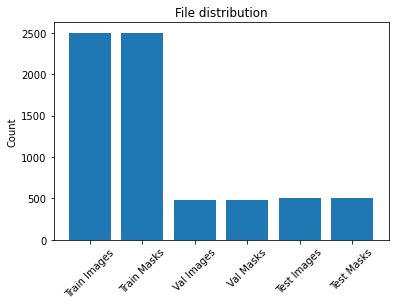

In [11]:
# Create tuple subclasses with named fields
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name the 30 classes

    'id'          , # An integer ID that is associated with this label.

    'categoryId'       , # IDs of labels which match to pixel values
                    # corresponding to the 8 main categories.

    'category'    , # The name of the category that this label belongs to
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #name                             id    catId   category
    Label(  'unlabeled'            ,  0 ,      0 , 'void'),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'),
    Label(  'rectification border' ,  2 ,      0 , 'void'),
    Label(  'out of roi'           ,  3 ,      0 , 'void'),
    Label(  'static'               ,  4 ,      0 , 'void'),
    Label(  'dynamic'              ,  5 ,      0 , 'void'),
    Label(  'ground'               ,  6 ,      0 , 'void'),
    Label(  'road'                 ,  7 ,      1 , 'flat'),
    Label(  'sidewalk'             ,  8 ,      1 , 'flat'),
    Label(  'parking'              ,  9 ,      1 , 'flat'),
    Label(  'rail track'           , 10 ,      1 , 'flat'),
    Label(  'building'             , 11 ,      2 , 'construction'),
    Label(  'wall'                 , 12 ,      2 , 'construction'),
    Label(  'fence'                , 13 ,      2 , 'construction'),
    Label(  'guard rail'           , 14 ,      2 , 'construction'),
    Label(  'bridge'               , 15 ,      2 , 'construction'),
    Label(  'tunnel'               , 16 ,      2 , 'construction'),
    Label(  'pole'                 , 17 ,      3 , 'object'),
    Label(  'polegroup'            , 18 ,      3 , 'object'),
    Label(  'traffic light'        , 19 ,      3 , 'object'),
    Label(  'traffic sign'         , 20 ,      3 , 'object'),
    Label(  'vegetation'           , 21 ,      4 , 'nature'),
    Label(  'terrain'              , 22 ,      4 , 'nature'),
    Label(  'sky'                  , 23 ,      5 , 'sky'),
    Label(  'person'               , 24 ,      6 , 'human'),
    Label(  'rider'                , 25 ,      6 , 'human'),
    Label(  'car'                  , 26 ,      7 , 'vehicle'),
    Label(  'truck'                , 27 ,      7 , 'vehicle'),
    Label(  'bus'                  , 28 ,      7 , 'vehicle'),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'),
    Label(  'train'                , 31 ,      7 , 'vehicle'),
    Label(  'motorcycle'           , 32 ,      7 , 'vehicle'),
    Label(  'bicycle'              , 33 ,      7 , 'vehicle'),
    Label(  'license plate'        , -1 ,      7 , 'vehicle')]

# Function to map labels and categories
def map_id2category(labels):
    """ This function maps the ~30 labels' IDs
        to the 8 main categories' IDs
    """
    cat_label = {label.id: label.categoryId for label in labels}
    
    # Get the mapping
    map_category = np.vectorize(cat_label.get)
    return map_category

# Set masks folders with 8 main categories
train_target_dir = 'data/train/masks'
val_target_dir = 'data/val/masks'
test_target_dir = 'data/test/masks'

# Function to create new masks 
def old_to_new_mask(img_path, msk30_path, msk8_path, labels):
    # Create lists
    img_list = os.listdir(img_path)
    msk30_list = os.listdir(msk30_path)

    # Sort list
    img_list.sort()
    msk30_list.sort()

    for i in range(0, len(img_list)):
        # Read images and masks
        img = cv2.imread(f'{img_path}/{img_list[i]}')/255
        msk30 = cv2.imread(f'{msk30_path}/{msk30_list[i]}', 
                           cv2.IMREAD_GRAYSCALE)
        
        # Convert msk30 to msk8
        map_category = map_id2category(labels)
        msk8 = map_category(msk30)

        # Save new masks on disk
        cv2.imwrite(f'{msk8_path}/{msk30_list[i]}', msk8)
        
# Save the masks for TRAIN
old_to_new_mask(train_input_dir, train_masks30_dir, train_target_dir, labels)

# Save the masks for VAL
old_to_new_mask(val_input_dir, val_masks30_dir, val_target_dir, labels)

# Save the masks for TEST
old_to_new_mask(test_input_dir, test_masks30_dir, test_target_dir, labels)

# Create dataset
height = [
    len(os.listdir(train_input_dir)), 
    len(os.listdir(train_target_dir)), 
    len(os.listdir(val_input_dir)), 
    len(os.listdir(val_target_dir)), 
    len(os.listdir(test_input_dir)), 
    len(os.listdir(test_target_dir)), 
]
bars = ('Train Images', 'Train Masks', 'Val Images', 'Val Masks', 'Test Images', 'Test Masks')
x_pos = np.arange(len(bars))

# Display len of differents directories
plt.figure()
plt.bar(x=x_pos, height=height)
plt.ylabel('Count')
plt.xticks(x_pos, bars, rotation=45)
plt.title('File distribution')
plt.show()

## III. Analyse exploratoire de données<a class="anchor" id="III"></a>

On va commencer par observer nos images et nos masques (initiaux et corrigés).

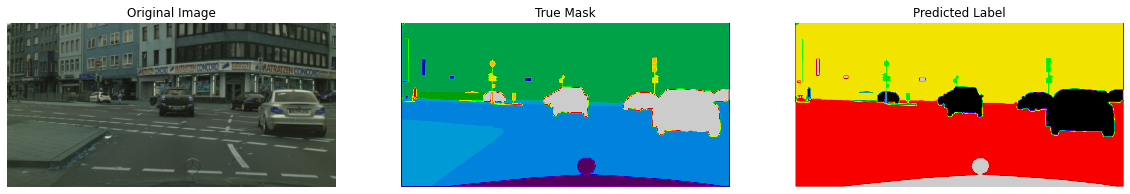

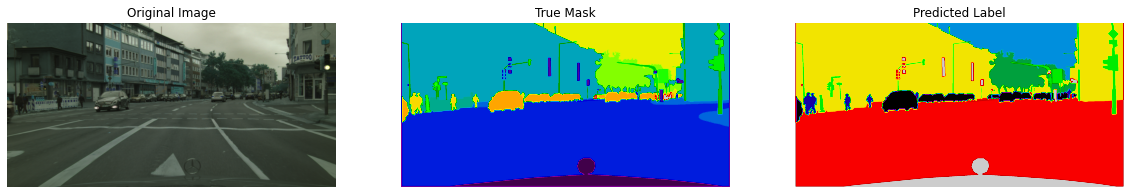

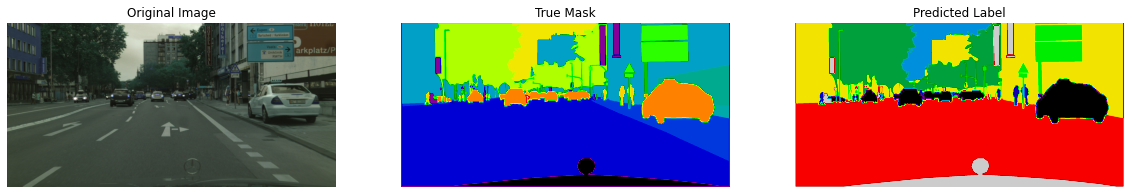

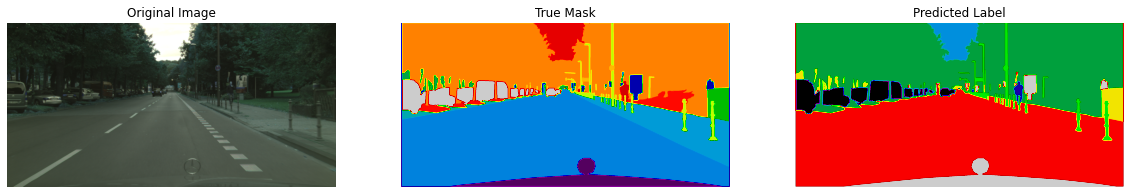

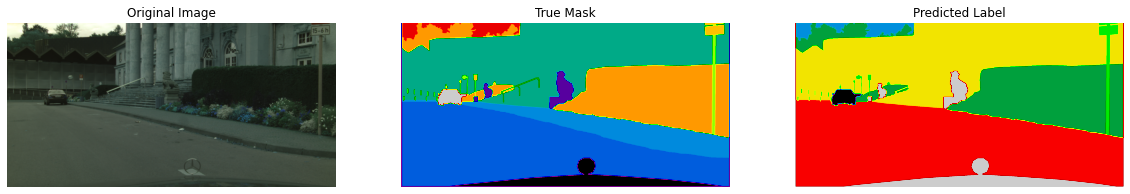

In [14]:
# Visualise original images, masks30 and masks8
def visualize_img_msk30_msk8(img_path, msk30_path, msk8_path, n=0):
    # Create lists
    img_list = os.listdir(img_path)
    msk30_list = os.listdir(msk30_path)
    msk8_list = os.listdir(msk8_path)

    # Sort list
    img_list.sort()
    msk30_list.sort()
    msk8_list.sort()

    for i in range(n, n+5):
        img = cv2.imread(f'{img_path}/{img_list[i]}')
        msk30 = cv2.imread(f'{msk30_path}/{msk30_list[i]}', 
                           cv2.IMREAD_GRAYSCALE)
        msk8 = cv2.imread(f'{msk8_path}/{msk8_list[i]}',
                          cv2.IMREAD_GRAYSCALE)
        
        # Plot
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 20))
        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax1.axis('off')
        ax2.imshow(msk30, cmap='nipy_spectral')
        ax2.set_title('True Mask')
        ax2.axis('off')
        ax3.imshow(msk8, cmap='nipy_spectral_r')
        ax3.set_title('Predicted Label')
        ax3.axis('off')
        plt.show()

# Call the function
visualize_img_msk30_msk8(train_input_dir, train_masks30_dir, train_target_dir, n=3)

Les résultats sont cohérents. Observons maintenant la distribution de nos classes. 

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:35<00:00, 26.31it/s]


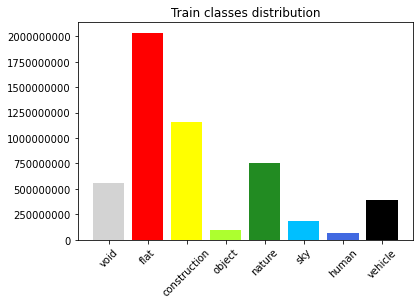

100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [00:17<00:00, 26.64it/s]


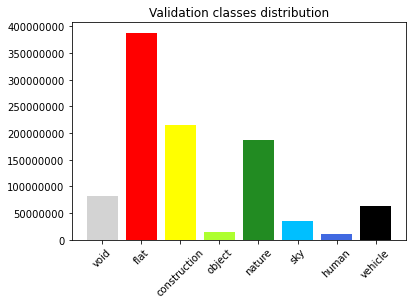

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.45it/s]


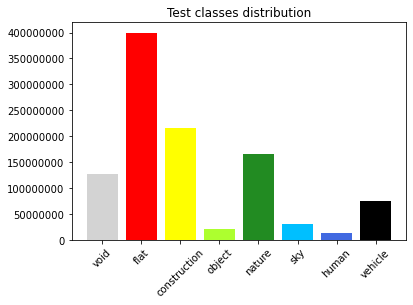

In [6]:
# Function to compute and plot classes' distribution
def class_distribution(mask_path, dataset='Train'):
    mask_list = os.listdir(mask_path)
    mask_list.sort()

    # Create an empty list
    sums = []

    # Load image data
    for i in tqdm(range(0, len(mask_list))):
        mask = cv2.imread(f'{mask_path}/{mask_list[i]}', cv2.IMREAD_GRAYSCALE)
        
        # Return a list of occurence of each unique label value
        (unique, counts) = np.unique(mask, return_counts=True)

        # Store the result in a list of dictionary
        sums.append(dict(zip(unique, counts)))

    # Instantiate a counter
    result_counter = Counter()

    # Iterate over elements in sums
    for elem in sums:
        for key, value in elem.items():
            result_counter[key] += value

    categ = {
        'void': 0,
        'flat': 1,
        'construction': 2, 
        'object': 3, 
        'nature': 4, 
        'sky': 5, 
        'human': 6, 
        'vehicle': 7
    }
    my_colors = [
        'lightgrey', 
        'red', 
        'yellow', 
        'greenyellow',
        'forestgreen', 
        'deepskyblue', 
        'royalblue', 
        'black'
    ]
    
    # Plot the classes distribution
    plt.figure()
    plt.bar(
        x=categ.keys(), 
        height=result_counter.values(),
        tick_label=list(categ.keys()), 
        color=my_colors
    )
    plt.xticks(rotation=45)
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(dataset +' classes distribution')
    plt.show()

# Call the function
class_distribution(train_target_dir, dataset='Train')
class_distribution(val_target_dir, dataset='Validation')
class_distribution(test_target_dir, dataset='Test')

Notre jeu de données contient des classes déséquilibrées, ce qui est une situation relativement fréquente sur les jeux de données. En effet, le masque **flat** apparaît par exemple plus de 2 fois plus fréquemment que le masque **nature**.

Cette information est importante lorsqu'il s'agit de mesurer la performance de nos modèles. En effet, il faudra le prendre en compte car le modèle prédira probablement plus souvent des classes sur-représentées que des classes sous-représentées.

## IV. Modélisation des données<a class="anchor" id="IV"></a>

### 1. U-net<a class="anchor" id="IV1"></a>

U-net est un des réseaux de neurones les plus utilisés pour la segmentation d’image. Son architecture est composée de deux "chemins". 

Le premier est le chemin de contraction, aussi appelé encodeur. Il est utilisé pour capturer le contexte d’une image. Il s’agit en fait d’un assemblage de couches de convolution et de couches de ” max pooling ” permettant de créer une carte de caractéristiques d’une image et de réduire sa taille pour diminuer le nombre de paramètres du réseau.

Le second chemin est celui de l’expansion symétrique, aussi appelé décodeur. Il permet aussi une localisation précise grâce à la convolution transposée.

#### a. Dice loss<a class="anchor" id="IV1a"></a>

In [7]:
def blur_img(img):
    """Add random blur to image, returns PIL image"""
    n = random.uniform(0, 2.0) # Generating random value for sigma
    blur_transform = iaa.Sequential([iaa.GaussianBlur(sigma=n)])
    img_blur = blur_transform(image=tensorflow.keras.preprocessing.image.img_to_array(img))

    return tensorflow.keras.preprocessing.image.array_to_img(img_blur)

def zoom_img(img,mask):
    """Add random zoom to image and mask, returns transformed PIL image and corresponding mask"""
    n = random.uniform(1, 5) # Generating random value for sigma
    zoom_transform = iaa.Sequential([iaa.Affine(scale=n, order=0)]) # uses order=0 to avoid artifacts in mask
    img_zoom = zoom_transform(image=tensorflow.keras.preprocessing.image.img_to_array(img))
    mask_zoom = zoom_transform(image=tensorflow.keras.preprocessing.image.img_to_array(mask))

    return (
        tensorflow.keras.preprocessing.image.array_to_img(img_zoom), 
        tensorflow.keras.preprocessing.image.array_to_img(mask_zoom,scale=False)
    )

def brightness_img(img):
    """Add random brightness to image, returns PIL image"""
    br_transform = iaa.Sequential([iaa.MultiplyBrightness((0.1, 2))])
    img_br = br_transform(image=tensorflow.keras.preprocessing.image.img_to_array(img).astype(np.uint8))
    
    return tensorflow.keras.preprocessing.image.array_to_img(img_br, scale=False)

def flip_img(img,mask):
    """Flips verticaly image, returns transformed PIL image and corresponding mask"""
    flip_transform = iaa.Sequential([iaa.Fliplr()])
    img_flip = flip_transform(image=tensorflow.keras.preprocessing.image.img_to_array(img))
    mask_flip = flip_transform(image=tensorflow.keras.preprocessing.image.img_to_array(mask))

    return (
        tensorflow.keras.preprocessing.image.array_to_img(img_flip),
        tensorflow.keras.preprocessing.image.array_to_img(mask_flip,scale=False)
    )

def create_mask(img,cats):
    """Creates an mask from image and segmentation categories
    
    Args:
      img - PIL image
      cats - dict {'cat1':[value1,value2,value3,etc...],'cat2':[value1,value2,value3,etc...]}
    
    Returns:
      A mask of type np.array of dimension (shape(img),len(cats))"""
    
    # Convert img to np.array
    img = tensorflow.keras.preprocessing.image.img_to_array(img, dtype=np.int32) 
    # Remove 1 dimension
    img = np.squeeze(img) 
    # Create a mask with zeros
    mask = np.zeros((img.shape[0], img.shape[1], len(cats)), dtype=int) 
    # Create a list of all values associated with categories
    flat_cat = [val for cat in list(cats.values()) for val in cat]
    ca_min = min(flat_cat)
    ca_max = max(flat_cat)
    cats_names = list(cats.keys())
    
    # For each values associated with a category, fill in the mask with the corresponding category number
    for i in range(ca_min, ca_max):
        for idx,name in enumerate(cats_names):
            if i in cats[name]:
                mask[:, :, idx] = np.logical_or(mask[:, :, idx], (img == i))
    return mask

def normalize_input_img(img):
    """Normalize PIL image to fall in [-1,1] range, returns 3D numpy array"""
    img = tensorflow.keras.preprocessing.image.img_to_array(img, dtype=np.int32)
    img = img / 127.5
    img -= 1
    return img


class seg_gen(Sequence):
    
    def __init__(
        self, 
        image_dir,
        mask_dir,
        batch_size,
        img_height,
        img_width,
        cats,
        sample_perc=100,
        aug_blur=False,
        aug_zoom=False,
        aug_brightness=False,
        aug_flip=False
    ):    
        self.image_dir = image_dir
        self.mask_dir =  mask_dir
        self.image_filename =  os.listdir(image_dir)
        self.image_filename.sort()
        self.mask_filename =  os.listdir(mask_dir)
        self.mask_filename.sort()
        self.sample_perc = sample_perc
        
        # Generate a sample
        rdm_index = random.sample(
            range(0, len(self.image_filename)), int(len(self.image_filename) * self.sample_perc / 100)
        )
        image_filename_sample = []
        for i in rdm_index:
            image_filename_sample.append(self.image_filename[i])
            
        mask_filename_sample = [] 
        for i in rdm_index:
            mask_filename_sample.append(self.mask_filename[i])
                
        self.image_filename = image_filename_sample
        self.mask_filename = mask_filename_sample
        
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.cats = cats
        self.sample_perc = sample_perc
        self.aug_blur = aug_blur
        self.aug_zoom = aug_zoom
        self.aug_brightness = aug_brightness
        self.aug_flip = aug_flip

    def __len__(self):
        return int(np.ceil(len(self.image_filename) / float(self.batch_size)))

    def __getitem__(self, idx):
        'generate one batch with random index'
        idx = np.random.randint(0, len(self.image_filename) - 1, self.batch_size) #generate random index for the batch
        batch_img, batch_mask = [], []
        
        for i in idx:
            # Filename
            img_file = self.image_dir + '/' + self.image_filename[i] 
            mask_file = self.mask_dir + '/' + self.mask_filename[i]
            
            # Load as PIL image and resize
            img = tensorflow.keras.preprocessing.image.load_img(img_file,target_size=(self.img_height, self.img_width))
            mask = tensorflow.keras.preprocessing.image.load_img(mask_file, target_size=(128, 256), color_mode="grayscale")
                        
            # Normalize image and create mask from greyscale image
            img_norm = normalize_input_img(img)
            mask_tensor = create_mask(mask,self.cats)            
          
            # Add to the batch
            batch_img.append(img_norm)
            batch_mask.append(mask_tensor)
            
            # Image augmentation
            if self.aug_blur:
                batch_img.append(normalize_input_img(blur_img(img)))
                batch_mask.append(mask_tensor) # When using blur augmentation,the mask is not changed
            
            if self.aug_zoom:
                zooms = zoom_img(img,mask)
                batch_img.append(normalize_input_img(zooms[0]))
                batch_mask.append(create_mask(zooms[1], self.cats))
             
            if self.aug_brightness:
                batch_img.append(normalize_input_img(brightness_img(img)))
                batch_mask.append(mask_tensor) # When using brightness augmentation,the mask is not changed
            
            if self.aug_flip:
                flips = flip_img(img,mask)
                batch_img.append(normalize_input_img(flips[0]))
                batch_mask.append(create_mask(flips[1],self.cats))                         
            
        return np.array(batch_img), np.array(batch_mask)

    
categories = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

train_gen = seg_gen(
    train_input_dir,
    train_target_dir,
    32,
    128,
    256,
    categories,
    sample_perc=20,
    aug_blur=False,
    aug_zoom=False,
    aug_brightness=False,
    aug_flip=False,
)

val_gen = seg_gen(
    val_input_dir,
    val_target_dir,
    32,
    128,
    256,
    categories,
    sample_perc=20,
    aug_blur=False,
    aug_zoom=False,
    aug_brightness=False,
    aug_flip=False,
)

test_gen = seg_gen(
    test_input_dir,
    test_target_dir,
    32,
    128,
    256,
    categories,
    sample_perc=10,
    aug_blur=False,
    aug_zoom=False,
    aug_brightness=False,
    aug_flip=False,
)

# Function to compute dice loss
def dice_loss(y_true, y_pred):
    y_true = tensorflow.cast(y_true, tensorflow.float32)
    y_pred = tensorflow.math.sigmoid(y_pred)
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

# Function to compute dice coefficient
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

# Set parameters & hyperparameters
epochs = 100
batch_size = 32

def unet(num_classes):
    inputs = Input(shape=(128, 256, 3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Build model
model_unet_dice = unet(8)
model_unet_dice.summary()

model_unet_dice.compile(
    optimizer="rmsprop", 
    loss=dice_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_dice = model_unet_dice.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size)
stop = time()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 128, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 8, 16, 256)  590080      ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 8, 16, 256)  1024        ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 16, 256)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 8, 16, 256)  590080      ['activation_8[0][0]']           
 spose)   

 activation_14 (Activation)     (None, 64, 128, 32)  0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 64, 128, 32)  9248       ['activation_14[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 64, 128, 32)  128        ['conv2d_transpose_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 128, 256, 64  0          ['add_5[0][0]']                  
                                )                                                                 
          

Pour évaluer nos modèles, nous allons utiliser 2 métriques d'évaluation :
* l'**Intersection-Over-Union** (IoU), également connu sous le nom d'indice Jaccard, est la zone de chevauchement entre la segmentation prédite et la segmentation réelle divisée par la zone d'union entre la segmentation prédite et la segmentation réelle. Cette métrique va de 0 à 1 (0 à 100 %), 0 signifiant aucun chevauchement et 1 signifiant une segmentation parfaitement superposée.
* le **coefficient de Dice** est similaire à l'indice de Jaccard (Intersection over Union). Ils sont positivement corrélés, ce qui signifie que si l'on dit que le modèle A est meilleur que le modèle B pour segmenter une image, alors l'autre dira la même chose. Comme l'IoU, ils vont tous deux de 0 à 1, 1 signifiant la plus grande similitude entre la prédiction et la vérité.

Nous allons également essayer différentes fonctions de perte afin de pouvoir sélectionner le modèle avec les meilleurs hyperparamètres. En premier lieu nous prendrons le **Dice loss**, ce dernier vient du coefficient de Dice. En général, le **Dice loss** fonctionne mieux lorsqu'elle est appliquée sur des images que sur des pixels uniques.

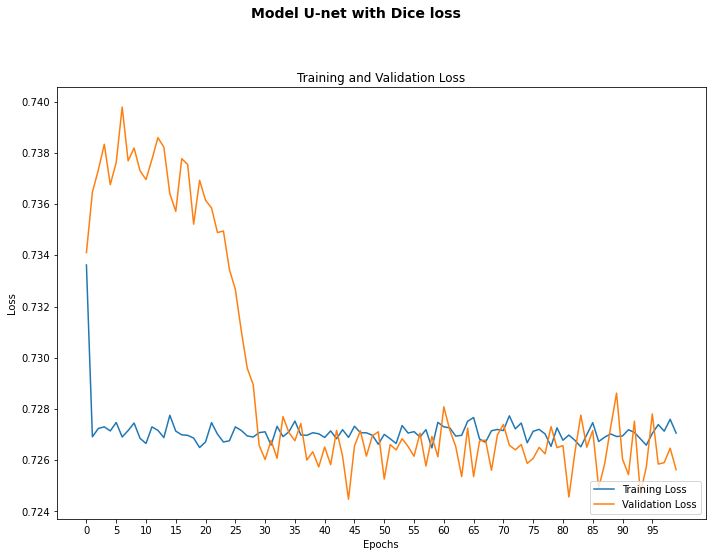

In [9]:
# Function to plot learning curves
def std_learning_curves(history, title, NUM_EPOCHS, loss, val_loss):
    plt.figure(figsize=(10, 20))

    plt.subplot(3, 1, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, NUM_EPOCHS, 5))
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Give a title
title = 'Model U-net with Dice loss'

# Loss
base_loss = base_history_dice.history['loss']
base_val_loss = base_history_dice.history['val_loss']
    
# Call function to plot learning curves
std_learning_curves(
    model_unet_dice, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [10]:
# Evaluate the model with Test set
results_dice = model_unet_dice.evaluate(test_gen, batch_size=batch_size)

performances = pd.DataFrame(
    {
        'U-net Dice loss': 
        [
            results_dice[1],
            results_dice[2],
            stop-start
        ]
    }, index=['IoU', 'Dice coefficient', 'Training time']
)
performances.head()

2/2 [==============================] - 5s 2s/step - loss: 0.7275 - io_u: 0.9776 - dice_coef: 0.9206


,U-net Dice loss
IoU,0.977563
Dice coefficient,0.920600
Training time,6224.462833


Passons à notre deuxième fonction de perte : **total loss**. 

#### b. Total loss<a class="anchor" id="IV1b"></a>

Le **total loss** correspond à une entropie croisée catégorielle pondérée par le **dice loss**.

In [11]:
categorical_cross_entropy = tensorflow.keras.losses.CategoricalCrossentropy()

def total_loss(y_true, y_pred):
    y_true = tensorflow.cast(y_true, tensorflow.float32)
    loss = categorical_cross_entropy(y_true, y_pred) + (3 * dice_loss(y_true, y_pred))
    return loss

model_unet_total = unet(8)
model_unet_total.compile(
    optimizer="rmsprop", 
    loss=total_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_total = model_unet_total.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size)
stop = time()

Epoch 1/100
16/16 [==============================] - 69s 4s/step - loss: 4.0001 - io_u_1: 0.8966 - dice_coef: 0.8232 - val_loss: 2.6771 - val_io_u_1: 0.8750 - val_dice_coef: 0.7679
Epoch 2/100
16/16 [==============================] - 65s 4s/step - loss: 2.4545 - io_u_1: 0.8811 - dice_coef: 0.9010 - val_loss: 2.6810 - val_io_u_1: 0.8750 - val_dice_coef: 0.8212
Epoch 3/100
16/16 [==============================] - 64s 4s/step - loss: 2.4551 - io_u_1: 0.8789 - dice_coef: 0.8929 - val_loss: 2.7482 - val_io_u_1: 0.8750 - val_dice_coef: 0.8518
Epoch 4/100
16/16 [==============================] - 65s 4s/step - loss: 2.7697 - io_u_1: 0.8792 - dice_coef: 0.8602 - val_loss: 2.5683 - val_io_u_1: 0.8750 - val_dice_coef: 0.9156
Epoch 5/100
16/16 [==============================] - 65s 4s/step - loss: 2.3966 - io_u_1: 0.8768 - dice_coef: 0.9097 - val_loss: 2.6269 - val_io_u_1: 0.8750 - val_dice_coef: 0.9129
Epoch 6/100
16/16 [==============================] - 66s 4s/step - loss: 2.3446 - io_u_1: 0.875

16/16 [==============================] - 65s 4s/step - loss: 2.2191 - io_u_1: 0.8780 - dice_coef: 0.9741 - val_loss: 2.3497 - val_io_u_1: 0.8780 - val_dice_coef: 0.9451
Epoch 47/100
16/16 [==============================] - 64s 4s/step - loss: 2.1932 - io_u_1: 0.8767 - dice_coef: 0.9839 - val_loss: 2.2657 - val_io_u_1: 0.8765 - val_dice_coef: 0.9666
Epoch 48/100
16/16 [==============================] - 65s 4s/step - loss: 2.1956 - io_u_1: 0.8769 - dice_coef: 0.9836 - val_loss: 2.4131 - val_io_u_1: 0.8756 - val_dice_coef: 0.9481
Epoch 49/100
16/16 [==============================] - 64s 4s/step - loss: 2.2002 - io_u_1: 0.8765 - dice_coef: 0.9818 - val_loss: 2.2710 - val_io_u_1: 0.8760 - val_dice_coef: 0.9677
Epoch 50/100
16/16 [==============================] - 65s 4s/step - loss: 2.2107 - io_u_1: 0.8777 - dice_coef: 0.9776 - val_loss: 2.3045 - val_io_u_1: 0.8785 - val_dice_coef: 0.9556
Epoch 51/100
16/16 [==============================] - 64s 4s/step - loss: 2.1909 - io_u_1: 0.8792 - dic

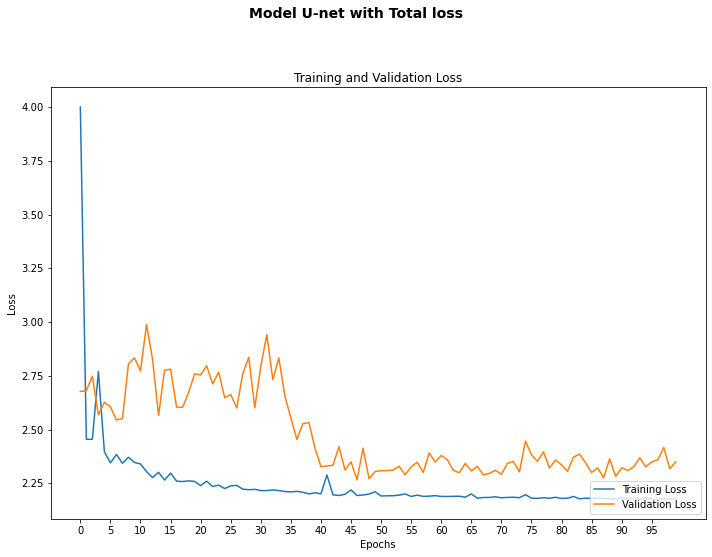

In [12]:
# Loss
base_loss = base_history_total.history['loss']
base_val_loss = base_history_total.history['val_loss']

# Give a title
title = 'Model U-net with Total loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_unet_total, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [13]:
# Evaluate the model with Test set
results_total = model_unet_total.evaluate(test_gen, batch_size=batch_size)
performances['U-net Total loss'] = [results_total[1], results_total[2], stop-start]
performances.head()

2/2 [==============================] - 6s 2s/step - loss: 2.3110 - io_u_1: 0.8878 - dice_coef: 0.9638


,U-net Dice loss,U-net Total loss
IoU,0.977563,0.887825
Dice coefficient,0.920600,0.963801
Training time,6224.462833,6494.797175


#### c. Balanced cross entropy<a class="anchor" id="IV1c"></a>

Le **Balanced cross entropy** est similaire au **weighted cross entropy** (variante de la **cross entropy** où tous les exemples positifs sont pondérés par un certain coefficient). La seule différence est que nous pondérons également les exemples négatifs.

In [14]:
def balanced_cross_entropy(beta):
    def loss(y_true, y_pred):
        weight_a = beta * tensorflow.cast(y_true, tensorflow.float32)
        weight_b = (1 - beta) * tensorflow.cast(1 - y_true, tensorflow.float32)

        o = (
            tensorflow.math.log1p(
                tensorflow.exp(-tensorflow.abs(y_pred))
            ) + tensorflow.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
        return tensorflow.reduce_mean(o)

    return loss

model_unet_balanced = unet(8)
model_unet_balanced.compile(
    optimizer="rmsprop", 
    loss=balanced_cross_entropy(0.3), 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_balanced = model_unet_balanced.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size)
stop = time()

Epoch 1/100
16/16 [==============================] - 70s 4s/step - loss: 0.4463 - io_u_2: 0.9669 - dice_coef: 0.8519 - val_loss: 0.4421 - val_io_u_2: 0.8932 - val_dice_coef: 0.9119
Epoch 2/100
16/16 [==============================] - 64s 4s/step - loss: 0.4415 - io_u_2: 0.9787 - dice_coef: 0.9248 - val_loss: 0.4426 - val_io_u_2: 0.9560 - val_dice_coef: 0.9072
Epoch 3/100
16/16 [==============================] - 65s 4s/step - loss: 0.4418 - io_u_2: 0.9774 - dice_coef: 0.9199 - val_loss: 0.4415 - val_io_u_2: 0.9632 - val_dice_coef: 0.9233
Epoch 4/100
16/16 [==============================] - 64s 4s/step - loss: 0.4411 - io_u_2: 0.9802 - dice_coef: 0.9299 - val_loss: 0.4422 - val_io_u_2: 0.9621 - val_dice_coef: 0.9139
Epoch 5/100
16/16 [==============================] - 65s 4s/step - loss: 0.4413 - io_u_2: 0.9792 - dice_coef: 0.9263 - val_loss: 0.4416 - val_io_u_2: 0.9644 - val_dice_coef: 0.9217
Epoch 6/100
16/16 [==============================] - 65s 4s/step - loss: 0.4415 - io_u_2: 0.978

16/16 [==============================] - 64s 4s/step - loss: 0.4417 - io_u_2: 0.9778 - dice_coef: 0.9215 - val_loss: 0.4420 - val_io_u_2: 0.9766 - val_dice_coef: 0.9170
Epoch 47/100
16/16 [==============================] - 65s 4s/step - loss: 0.4412 - io_u_2: 0.9799 - dice_coef: 0.9288 - val_loss: 0.4410 - val_io_u_2: 0.9807 - val_dice_coef: 0.9319
Epoch 48/100
16/16 [==============================] - 64s 4s/step - loss: 0.4411 - io_u_2: 0.9800 - dice_coef: 0.9293 - val_loss: 0.4407 - val_io_u_2: 0.9820 - val_dice_coef: 0.9365
Epoch 49/100
16/16 [==============================] - 64s 4s/step - loss: 0.4414 - io_u_2: 0.9791 - dice_coef: 0.9260 - val_loss: 0.4410 - val_io_u_2: 0.9807 - val_dice_coef: 0.9316
Epoch 50/100
16/16 [==============================] - 64s 4s/step - loss: 0.4419 - io_u_2: 0.9771 - dice_coef: 0.9190 - val_loss: 0.4411 - val_io_u_2: 0.9801 - val_dice_coef: 0.9298
Epoch 51/100
16/16 [==============================] - 65s 4s/step - loss: 0.4411 - io_u_2: 0.9803 - dic

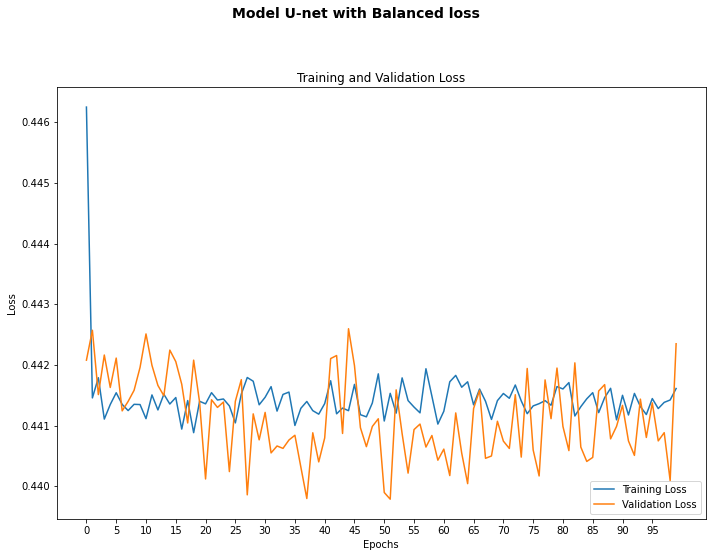

In [15]:
# Loss
base_loss = base_history_balanced.history['loss']
base_val_loss = base_history_balanced.history['val_loss']

# Give a title
title = 'Model U-net with Balanced loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_unet_balanced, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [16]:
# Evaluate the model with Test set
results_balanced = model_unet_balanced.evaluate(test_gen, batch_size=batch_size)
performances['U-net Balanced loss'] = [results_balanced[1], results_balanced[2], stop-start]
performances.head()

2/2 [==============================] - 6s 2s/step - loss: 0.4411 - io_u_2: 0.9804 - dice_coef: 0.9306


,U-net Dice loss,U-net Total loss,U-net Balanced loss
IoU,0.977563,0.887825,0.980365
Dice coefficient,0.920600,0.963801,0.930598
Training time,6224.462833,6494.797175,6495.223846


Sur les simulations du modèle U-net, celui avec la meilleure performance est celui utilisant le **Balanced cross entropy**. En revanche, le modèle le plus rapide dans son temps d'entraînement est celui utilisant le **Dice loss**. Les différences de performance étant faibles (inférieures à 2%), nous nous dirigerons plutôt vers le modèle avec **Dice loss** pour les gains en temps d'entraînement qu'il apporte.

### 2. VGG-16<a class="anchor" id="IV2"></a>

**VGG-16** est un modèle de réseau de neurones comprenant 16 couches profondes: 13 couches de convolution et 3 fully-connected. Nous allons remplacer les dernières couches fully-connected qui permettent de classifier l'image dans une des 1000 classes ImageNet par un classifieur plus adapté à notre problème.

#### a. Dice loss<a class="anchor" id="IV2a"></a>

In [18]:
def fcn(classes=8):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128, 256, 3))

    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    output_layer = Activation('softmax')(deconv_9)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

model_vgg_dice = fcn()
model_vgg_dice.summary()
model_vgg_dice.compile(
    optimizer="rmsprop", 
    loss=dice_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_dice_vgg = model_vgg_dice.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size)
stop = time() 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

Epoch 6/100
16/16 [==============================] - 139s 9s/step - loss: 0.7672 - io_u_3: 0.8596 - dice_coef: 0.4713 - val_loss: 0.7676 - val_io_u_3: 0.8584 - val_dice_coef: 0.4666
Epoch 7/100
16/16 [==============================] - 139s 9s/step - loss: 0.7670 - io_u_3: 0.8601 - dice_coef: 0.4735 - val_loss: 0.7671 - val_io_u_3: 0.8597 - val_dice_coef: 0.4719
Epoch 8/100
16/16 [==============================] - 138s 9s/step - loss: 0.7672 - io_u_3: 0.8595 - dice_coef: 0.4710 - val_loss: 0.7672 - val_io_u_3: 0.8595 - val_dice_coef: 0.4711
Epoch 9/100
16/16 [==============================] - 137s 8s/step - loss: 0.7673 - io_u_3: 0.8593 - dice_coef: 0.4702 - val_loss: 0.7667 - val_io_u_3: 0.8609 - val_dice_coef: 0.4769
Epoch 10/100
16/16 [==============================] - 137s 9s/step - loss: 0.7672 - io_u_3: 0.8596 - dice_coef: 0.4716 - val_loss: 0.7671 - val_io_u_3: 0.8599 - val_dice_coef: 0.4729
Epoch 11/100
16/16 [==============================] - 138s 9s/step - loss: 0.7673 - io_u_

Epoch 51/100
16/16 [==============================] - 138s 9s/step - loss: 0.7672 - io_u_3: 0.8595 - dice_coef: 0.4713 - val_loss: 0.7668 - val_io_u_3: 0.8607 - val_dice_coef: 0.4758
Epoch 52/100
16/16 [==============================] - 138s 9s/step - loss: 0.7672 - io_u_3: 0.8596 - dice_coef: 0.4715 - val_loss: 0.7670 - val_io_u_3: 0.8600 - val_dice_coef: 0.4732
Epoch 53/100
16/16 [==============================] - 136s 8s/step - loss: 0.7672 - io_u_3: 0.8597 - dice_coef: 0.4718 - val_loss: 0.7669 - val_io_u_3: 0.8604 - val_dice_coef: 0.4746
Epoch 54/100
16/16 [==============================] - 136s 8s/step - loss: 0.7673 - io_u_3: 0.8592 - dice_coef: 0.4700 - val_loss: 0.7674 - val_io_u_3: 0.8590 - val_dice_coef: 0.4691
Epoch 55/100
16/16 [==============================] - 136s 8s/step - loss: 0.7672 - io_u_3: 0.8595 - dice_coef: 0.4710 - val_loss: 0.7667 - val_io_u_3: 0.8610 - val_dice_coef: 0.4771
Epoch 56/100
16/16 [==============================] - 137s 9s/step - loss: 0.7671 - i

Epoch 96/100
16/16 [==============================] - 136s 8s/step - loss: 0.7672 - io_u_3: 0.8595 - dice_coef: 0.4710 - val_loss: 0.7671 - val_io_u_3: 0.8597 - val_dice_coef: 0.4721
Epoch 97/100
16/16 [==============================] - 136s 8s/step - loss: 0.7670 - io_u_3: 0.8600 - dice_coef: 0.4731 - val_loss: 0.7674 - val_io_u_3: 0.8589 - val_dice_coef: 0.4685
Epoch 98/100
16/16 [==============================] - 138s 9s/step - loss: 0.7672 - io_u_3: 0.8596 - dice_coef: 0.4713 - val_loss: 0.7673 - val_io_u_3: 0.8593 - val_dice_coef: 0.4701
Epoch 99/100
16/16 [==============================] - 139s 9s/step - loss: 0.7673 - io_u_3: 0.8592 - dice_coef: 0.4698 - val_loss: 0.7669 - val_io_u_3: 0.8604 - val_dice_coef: 0.4748
Epoch 100/100
16/16 [==============================] - 137s 8s/step - loss: 0.7673 - io_u_3: 0.8593 - dice_coef: 0.4704 - val_loss: 0.7670 - val_io_u_3: 0.8601 - val_dice_coef: 0.4734


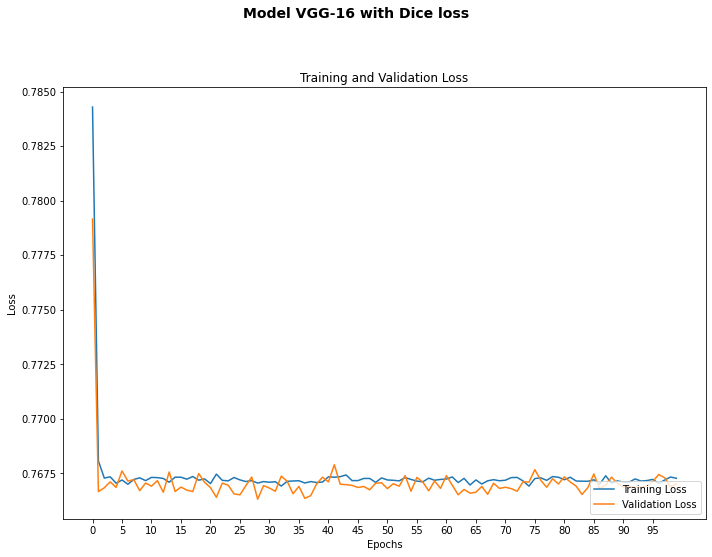

In [19]:
# Loss
base_loss = base_history_dice_vgg.history['loss']
base_val_loss = base_history_dice_vgg.history['val_loss']

# Give a title
title = 'Model VGG-16 with Dice loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_vgg_dice, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [20]:
# Evaluate the model with Test set
results_dice = model_vgg_dice.evaluate(test_gen, batch_size=batch_size)
performances['VGG-16 Dice loss'] = [results_dice[1], results_dice[2], stop-start]
performances.head()

2/2 [==============================] - 7s 3s/step - loss: 0.7670 - io_u_3: 0.8601 - dice_coef: 0.4737


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss
IoU,0.977563,0.887825,0.980365,0.860144
Dice coefficient,0.920600,0.963801,0.930598,0.473710
Training time,6224.462833,6494.797175,6495.223846,13741.885128


#### b. Total loss<a class="anchor" id="IV2b"></a>

In [21]:
model_vgg_total = fcn()
model_vgg_total.compile(
    optimizer="rmsprop", 
    loss=total_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
) 
start = time()
base_history_total_vgg = model_vgg_total.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size)
stop = time()

Epoch 1/100
16/16 [==============================] - 145s 9s/step - loss: 6186.1069 - io_u_4: 0.8690 - dice_coef: 0.1376 - val_loss: 4.3470 - val_io_u_4: 0.8750 - val_dice_coef: 0.1510
Epoch 2/100
16/16 [==============================] - 140s 9s/step - loss: 4.3172 - io_u_4: 0.8750 - dice_coef: 0.1581 - val_loss: 4.2559 - val_io_u_4: 0.8750 - val_dice_coef: 0.1615
Epoch 3/100
16/16 [==============================] - 142s 9s/step - loss: 4.2270 - io_u_4: 0.8750 - dice_coef: 0.1749 - val_loss: 4.1711 - val_io_u_4: 0.8750 - val_dice_coef: 0.1773
Epoch 4/100
16/16 [==============================] - 141s 9s/step - loss: 4.1192 - io_u_4: 0.8750 - dice_coef: 0.1931 - val_loss: 4.0885 - val_io_u_4: 0.8750 - val_dice_coef: 0.1900
Epoch 5/100
16/16 [==============================] - 141s 9s/step - loss: 4.0296 - io_u_4: 0.8750 - dice_coef: 0.2096 - val_loss: 3.9895 - val_io_u_4: 0.8750 - val_dice_coef: 0.2239
Epoch 6/100
16/16 [==============================] - 141s 9s/step - loss: 3.9573 - io_u

Epoch 46/100
16/16 [==============================] - 141s 9s/step - loss: 2.2765 - io_u_4: 0.8819 - dice_coef: 0.9489 - val_loss: 2.2827 - val_io_u_4: 0.8772 - val_dice_coef: 0.9423
Epoch 47/100
16/16 [==============================] - 143s 9s/step - loss: 2.3034 - io_u_4: 0.8805 - dice_coef: 0.9410 - val_loss: 2.2795 - val_io_u_4: 0.8760 - val_dice_coef: 0.9431
Epoch 48/100
16/16 [==============================] - 142s 9s/step - loss: 2.2620 - io_u_4: 0.8815 - dice_coef: 0.9525 - val_loss: 2.2512 - val_io_u_4: 0.8779 - val_dice_coef: 0.9574
Epoch 49/100
16/16 [==============================] - 143s 9s/step - loss: 2.2559 - io_u_4: 0.8807 - dice_coef: 0.9550 - val_loss: 2.2803 - val_io_u_4: 0.8759 - val_dice_coef: 0.9512
Epoch 50/100
16/16 [==============================] - 143s 9s/step - loss: 2.2785 - io_u_4: 0.8782 - dice_coef: 0.9466 - val_loss: 2.2748 - val_io_u_4: 0.8823 - val_dice_coef: 0.9543
Epoch 51/100
16/16 [==============================] - 143s 9s/step - loss: 2.2467 - i

Epoch 91/100
16/16 [==============================] - 146s 9s/step - loss: 2.2006 - io_u_4: 0.9195 - dice_coef: 0.9808 - val_loss: 2.2703 - val_io_u_4: 0.9313 - val_dice_coef: 0.9705
Epoch 92/100
16/16 [==============================] - 144s 9s/step - loss: 2.2202 - io_u_4: 0.9170 - dice_coef: 0.9734 - val_loss: 2.3021 - val_io_u_4: 0.9105 - val_dice_coef: 0.9587
Epoch 93/100
16/16 [==============================] - 144s 9s/step - loss: 2.1936 - io_u_4: 0.9296 - dice_coef: 0.9838 - val_loss: 2.2783 - val_io_u_4: 0.9307 - val_dice_coef: 0.9714
Epoch 94/100
16/16 [==============================] - 144s 9s/step - loss: 2.1954 - io_u_4: 0.9275 - dice_coef: 0.9834 - val_loss: 2.2753 - val_io_u_4: 0.9155 - val_dice_coef: 0.9650
Epoch 95/100
16/16 [==============================] - 143s 9s/step - loss: 2.6986 - io_u_4: 0.9079 - dice_coef: 0.9502 - val_loss: 2.2566 - val_io_u_4: 0.8846 - val_dice_coef: 0.9572
Epoch 96/100
16/16 [==============================] - 143s 9s/step - loss: 2.2131 - i

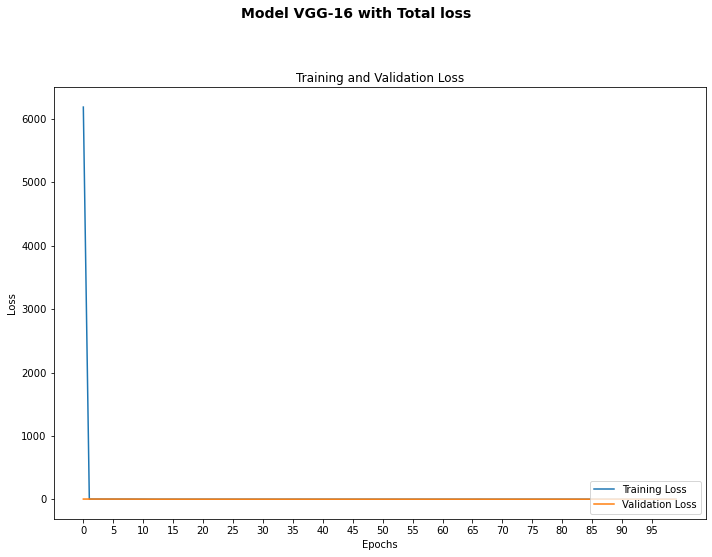

In [22]:
# Loss
base_loss = base_history_total_vgg.history['loss']
base_val_loss = base_history_total_vgg.history['val_loss']

# Give a title
title = 'Model VGG-16 with Total loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_vgg_total, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [23]:
# Evaluate the model with Test set
results_total = model_vgg_total.evaluate(test_gen, batch_size=batch_size)
performances['VGG-16 Total loss'] = [results_total[1], results_total[2], stop-start]
performances.head()

2/2 [==============================] - 7s 3s/step - loss: 2.2348 - io_u_4: 0.9349 - dice_coef: 0.9730


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646


#### c. Balanced cross entropy<a class="anchor" id="IV2c"></a>

In [24]:
model_vgg_balanced = fcn()
model_vgg_balanced.compile(
    optimizer="rmsprop", 
    loss=balanced_cross_entropy(0.3), 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_balanced_vgg = model_vgg_balanced.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size
)
stop = time()

Epoch 1/100
16/16 [==============================] - 163s 10s/step - loss: 0.4898 - io_u_5: 0.8067 - dice_coef: 0.2139 - val_loss: 0.4880 - val_io_u_5: 0.8054 - val_dice_coef: 0.2454
Epoch 2/100
16/16 [==============================] - 148s 9s/step - loss: 0.4854 - io_u_5: 0.8161 - dice_coef: 0.2830 - val_loss: 0.4817 - val_io_u_5: 0.8273 - val_dice_coef: 0.3374
Epoch 3/100
16/16 [==============================] - 148s 9s/step - loss: 0.4764 - io_u_5: 0.8598 - dice_coef: 0.4096 - val_loss: 0.4656 - val_io_u_5: 0.8981 - val_dice_coef: 0.5704
Epoch 4/100
16/16 [==============================] - 149s 9s/step - loss: 0.4673 - io_u_5: 0.8927 - dice_coef: 0.5456 - val_loss: 0.4625 - val_io_u_5: 0.9128 - val_dice_coef: 0.6143
Epoch 5/100
16/16 [==============================] - 149s 9s/step - loss: 0.4616 - io_u_5: 0.9117 - dice_coef: 0.6237 - val_loss: 0.4598 - val_io_u_5: 0.8864 - val_dice_coef: 0.6448
Epoch 6/100
16/16 [==============================] - 149s 9s/step - loss: 0.4559 - io_u_5

Epoch 46/100
16/16 [==============================] - 149s 9s/step - loss: 0.4401 - io_u_5: 0.9814 - dice_coef: 0.9427 - val_loss: 0.4407 - val_io_u_5: 0.9753 - val_dice_coef: 0.9341
Epoch 47/100
16/16 [==============================] - 150s 9s/step - loss: 0.4397 - io_u_5: 0.9829 - dice_coef: 0.9489 - val_loss: 0.4401 - val_io_u_5: 0.9820 - val_dice_coef: 0.9446
Epoch 48/100
16/16 [==============================] - 150s 9s/step - loss: 0.4395 - io_u_5: 0.9846 - dice_coef: 0.9536 - val_loss: 0.4390 - val_io_u_5: 0.9856 - val_dice_coef: 0.9599
Epoch 49/100
16/16 [==============================] - 149s 9s/step - loss: 0.4388 - io_u_5: 0.9877 - dice_coef: 0.9637 - val_loss: 0.4392 - val_io_u_5: 0.9844 - val_dice_coef: 0.9576
Epoch 50/100
16/16 [==============================] - 151s 9s/step - loss: 0.4391 - io_u_5: 0.9865 - dice_coef: 0.9595 - val_loss: 0.4393 - val_io_u_5: 0.9869 - val_dice_coef: 0.9561
Epoch 51/100
16/16 [==============================] - 151s 9s/step - loss: 0.4388 - i

Epoch 91/100
16/16 [==============================] - 151s 9s/step - loss: 0.4377 - io_u_5: 0.9933 - dice_coef: 0.9796 - val_loss: 0.4387 - val_io_u_5: 0.9892 - val_dice_coef: 0.9651
Epoch 92/100
16/16 [==============================] - 150s 9s/step - loss: 0.4375 - io_u_5: 0.9943 - dice_coef: 0.9830 - val_loss: 0.4384 - val_io_u_5: 0.9903 - val_dice_coef: 0.9698
Epoch 93/100
16/16 [==============================] - 150s 9s/step - loss: 0.4376 - io_u_5: 0.9939 - dice_coef: 0.9815 - val_loss: 0.4385 - val_io_u_5: 0.9901 - val_dice_coef: 0.9675
Epoch 94/100
16/16 [==============================] - 148s 9s/step - loss: 0.4374 - io_u_5: 0.9943 - dice_coef: 0.9832 - val_loss: 0.4385 - val_io_u_5: 0.9898 - val_dice_coef: 0.9672
Epoch 95/100
16/16 [==============================] - 148s 9s/step - loss: 0.4374 - io_u_5: 0.9947 - dice_coef: 0.9842 - val_loss: 0.4381 - val_io_u_5: 0.9910 - val_dice_coef: 0.9737
Epoch 96/100
16/16 [==============================] - 149s 9s/step - loss: 0.4377 - i

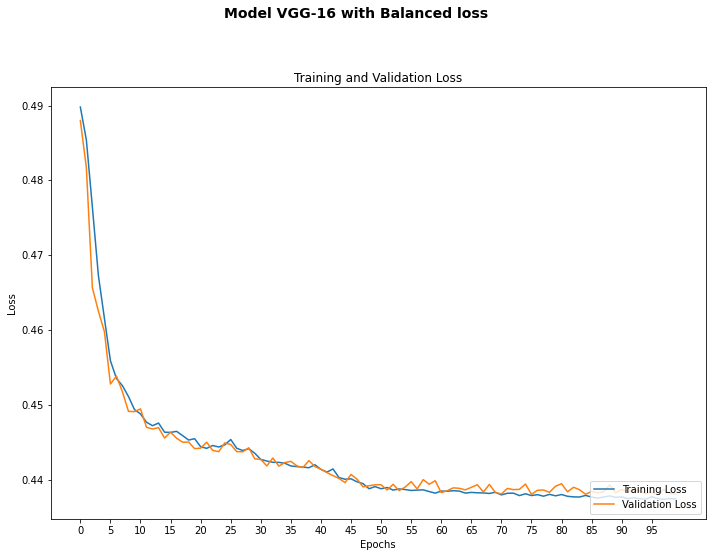

In [25]:
# Loss
base_loss = base_history_balanced_vgg.history['loss']
base_val_loss = base_history_balanced_vgg.history['val_loss']

# Give a title
title = 'Model VGG-16 with Balanced loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_vgg_balanced, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [26]:
# Evaluate the model with Test set
results_balanced = model_vgg_balanced.evaluate(test_gen, batch_size=batch_size)
performances['VGG-16 Balanced loss'] = [results_balanced[1], results_balanced[2], stop-start]
performances.head()

2/2 [==============================] - 7s 3s/step - loss: 0.4382 - io_u_5: 0.9909 - dice_coef: 0.9717


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314


### 3. FCN8<a class="anchor" id="IV3"></a>

FCN8 (Fully Convolutional Network) est une architecture utilisée principalement pour la segmentation sémantique. Il utilise uniquement des couches connectées localement, telles que la convolution, le pooling et le suréchantillonnage. Éviter l'utilisation de couches denses signifie moins de paramètres ce qui rend les réseaux plus rapides à former. Cela signifie également qu'un FCN peut fonctionner pour des tailles d'image variables étant donné que toutes les connexions sont locales.

Le réseau se compose d'un chemin de sous-échantillonnage, utilisé pour extraire et interpréter le contexte, et d'un chemin de suréchantillonnage, qui permet la localisation.

Les FCN utilisent également des connexions de saut pour récupérer les informations spatiales à grain fin perdues dans le chemin de sous-échantillonnage.

#### a. Dice loss<a class="anchor" id="IV3a"></a>

In [40]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
    '''
    Defines a block in the VGG network.

    Args:
    x (tensor) -- input image
    n_convs (int) -- number of convolution layers to append
    filters (int) -- number of filters for the convolution layers
    activation (string or object) -- activation to use in the convolution
    pool_size (int) -- size of the pooling layer
    pool_stried (int) -- stride of the pooling layer
    block_name (string) -- name of the block

    Returns:
    tensor containing the max-pooled output of the convolutions
    '''

    for i in range(n_convs):
        x = tensorflow.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_size,
            activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)
    
    x = tensorflow.keras.layers.MaxPooling2D(
        pool_size=pool_size, strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)
    return x

def VGG_16(image_input):
    '''
    This function defines the VGG encoder.

    Args:
    image_input (tensor) - batch of images

    Returns:
    tuple of tensors - output of all encoder blocks plus the final convolution layer
    '''
    # create 5 blocks with increasing filters at each stage. 
    # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
    x = block(image_input,n_convs=2, filters=64, kernel_size=(3, 3), 
            activation='relu',pool_size=(2, 2), pool_stride=(2, 2), block_name='block1')
    p1= x

    x = block(x,n_convs=2, filters=128, kernel_size=(3, 3),
            activation='relu',pool_size=(2, 2), pool_stride=(2, 2), block_name='block2')
    p2 = x

    x = block(x,n_convs=3, filters=256, kernel_size=(3, 3), 
            activation='relu',pool_size=(2, 2), pool_stride=(2, 2), block_name='block3')
    p3 = x

    x = block(x,n_convs=3, filters=512, kernel_size=(3, 3), 
            activation='relu',pool_size=(2, 2), pool_stride=(2, 2), block_name='block4')
    p4 = x

    x = block(x,n_convs=3, filters=512, kernel_size=(3, 3), 
            activation='relu',pool_size=(2, 2), pool_stride=(2, 2), block_name='block5')
    p5 = x

    # create the vgg model
    vgg  = tensorflow.keras.Model(image_input, p5)

    # number of filters for the output convolutional layers
    n = 4096

    # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
    # we can extract more features by chaining two more convolution layers.
    c6 = tensorflow.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(p5)
    c7 = tensorflow.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)

    # return the outputs at each stage. you will only need two of these in this particular exercise 
    # but we included it all in case you want to experiment with other types of decoders.
    return (p1, p2, p3, p4, c7)

def fcn8_decoder(convs, n_classes):
    '''
    Defines the FCN 8 decoder.

    Args:
    convs (tuple of tensors) - output of the encoder network
    n_classes (int) - number of classes

    Returns:
    tensor with shape (height, width, n_classes) containing class probabilities
    '''

    # unpack the output of the encoder
    f1, f2, f3, f4, f5 = convs

    # upsample the output of the encoder then crop extra pixels that were introduced
    o = tensorflow.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False)(f5)
    o = tensorflow.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = (tensorflow.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same'))(o2)

    # add the results of the upsampling and pool 4 prediction
    o = tensorflow.keras.layers.Add()([o, o2])

    # upsample the resulting tensor of the operation you just did
    o = (tensorflow.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False))(o)
    o = tensorflow.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same'))(o2)

    # add the results of the upsampling and pool 3 prediction
    o = tensorflow.keras.layers.Add()([o, o2])

    # upsample up to the size of the original image
    o = tensorflow.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8, 8), strides=(8, 8), use_bias=False)(o)

    # append a softmax to get the class probabilities
    o = (tensorflow.keras.layers.Activation('softmax'))(o)

    return o


def segmentation_model():
    '''
    Defines the final segmentation model by chaining together the encoder and decoder.

    Returns:
    keras Model that connects the encoder and decoder networks of the segmentation model
    '''

    inputs = tensorflow.keras.layers.Input(shape=(128, 256, 3))
    convs = VGG_16(image_input=inputs)
    outputs = fcn8_decoder(convs, 8)
    model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)
    return model

model_fcn8_dice = segmentation_model()
model_fcn8_dice.summary()

model_fcn8_dice.compile(
    optimizer="rmsprop", 
    loss=dice_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_fcn8_dice = model_fcn8_dice.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size
)
stop = time()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

Epoch 48/100
16/16 [==============================] - 263s 16s/step - loss: 0.7435 - io_u_2: 0.9282 - dice_coef: 0.7393 - val_loss: 0.7424 - val_io_u_2: 0.9315 - val_dice_coef: 0.7517
Epoch 49/100
16/16 [==============================] - 263s 16s/step - loss: 0.7431 - io_u_2: 0.9294 - dice_coef: 0.7440 - val_loss: 0.7419 - val_io_u_2: 0.9332 - val_dice_coef: 0.7580
Epoch 50/100
16/16 [==============================] - 264s 16s/step - loss: 0.7436 - io_u_2: 0.9280 - dice_coef: 0.7385 - val_loss: 0.7422 - val_io_u_2: 0.9323 - val_dice_coef: 0.7547
Epoch 51/100
16/16 [==============================] - 266s 16s/step - loss: 0.7435 - io_u_2: 0.9283 - dice_coef: 0.7396 - val_loss: 0.7422 - val_io_u_2: 0.9322 - val_dice_coef: 0.7544
Epoch 52/100
16/16 [==============================] - 263s 16s/step - loss: 0.7436 - io_u_2: 0.9278 - dice_coef: 0.7380 - val_loss: 0.7420 - val_io_u_2: 0.9328 - val_dice_coef: 0.7566
Epoch 53/100
16/16 [==============================] - 260s 16s/step - loss: 0.74

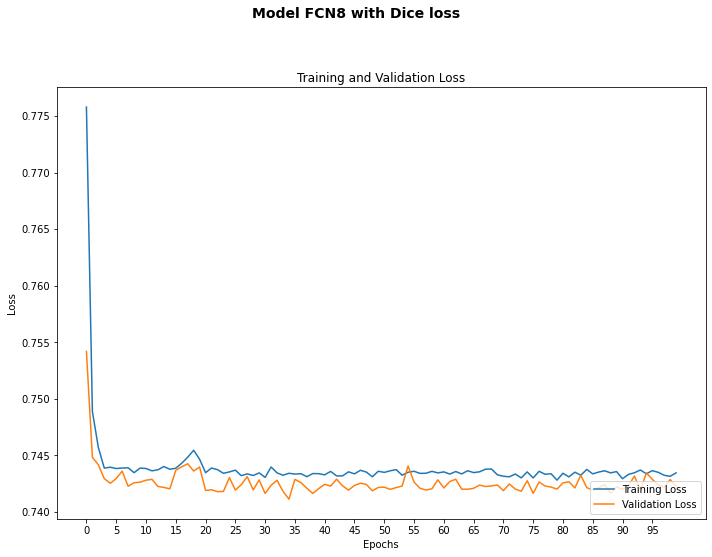

In [41]:
# Loss
base_loss = base_history_fcn8_dice.history['loss']
base_val_loss = base_history_fcn8_dice.history['val_loss']

# Give a title
title = 'Model FCN8 with Dice loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_fcn8_dice, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [42]:
# Evaluate the model with Test set
results_dice = model_fcn8_dice.evaluate(test_gen, batch_size=batch_size)
performances['FCN8 Dice loss'] = [results_dice[1], results_dice[2], stop-start]
performances.head()

2/2 [==============================] - 7s 3s/step - loss: 0.7431 - io_u_2: 0.9294 - dice_coef: 0.7438


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss,U-net Augmented Total loss,U-net Augmented Balanced loss,VGG-16 Augmented Dice loss,VGG-16 Augmented Total loss,VGG-16 Augmented Balanced loss,FCN8 Dice loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985,0.763196,0.944746,0.745015,0.813090,0.950786,0.929387
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430,0.962638,0.906425,0.452401,0.961118,0.917195,0.743814
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259,25642.705065,28087.876644,74760.303561,73406.170201,74565.478434,26066.356232


#### b. Total loss<a class="anchor" id="IV3b"></a>

In [43]:
# instantiate the model and see how it looks
model_fcn8_total = segmentation_model()

model_fcn8_total.compile(
    optimizer="rmsprop", 
    loss=total_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_fcn8_total = model_fcn8_total.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size
)
stop = time()

Epoch 1/100
16/16 [==============================] - 241s 15s/step - loss: 57.5463 - io_u_3: 0.8714 - dice_coef: 0.1512 - val_loss: 4.3967 - val_io_u_3: 0.8750 - val_dice_coef: 0.1353
Epoch 2/100
16/16 [==============================] - 242s 15s/step - loss: 4.2182 - io_u_3: 0.8750 - dice_coef: 0.2008 - val_loss: 4.0748 - val_io_u_3: 0.8750 - val_dice_coef: 0.2698
Epoch 3/100
16/16 [==============================] - 238s 15s/step - loss: 4.0366 - io_u_3: 0.8750 - dice_coef: 0.2512 - val_loss: 3.9513 - val_io_u_3: 0.8750 - val_dice_coef: 0.3152
Epoch 4/100
16/16 [==============================] - 245s 15s/step - loss: 3.8997 - io_u_3: 0.8750 - dice_coef: 0.2927 - val_loss: 3.7688 - val_io_u_3: 0.8750 - val_dice_coef: 0.3695
Epoch 5/100
16/16 [==============================] - 257s 16s/step - loss: 3.6882 - io_u_3: 0.8750 - dice_coef: 0.3633 - val_loss: 3.4896 - val_io_u_3: 0.8750 - val_dice_coef: 0.4759
Epoch 6/100
16/16 [==============================] - 257s 16s/step - loss: 3.2703 - 

16/16 [==============================] - 253s 16s/step - loss: 2.3810 - io_u_3: 0.8753 - dice_coef: 0.8904 - val_loss: 2.3722 - val_io_u_3: 0.8752 - val_dice_coef: 0.8910
Epoch 90/100
16/16 [==============================] - 252s 16s/step - loss: 2.3889 - io_u_3: 0.8755 - dice_coef: 0.8853 - val_loss: 2.3760 - val_io_u_3: 0.8752 - val_dice_coef: 0.8878
Epoch 91/100
16/16 [==============================] - 250s 16s/step - loss: 2.3930 - io_u_3: 0.8753 - dice_coef: 0.8831 - val_loss: 2.3750 - val_io_u_3: 0.8752 - val_dice_coef: 0.8952
Epoch 92/100
16/16 [==============================] - 250s 16s/step - loss: 2.3752 - io_u_3: 0.8754 - dice_coef: 0.8926 - val_loss: 2.3943 - val_io_u_3: 0.8757 - val_dice_coef: 0.9073
Epoch 93/100
16/16 [==============================] - 237s 15s/step - loss: 2.4017 - io_u_3: 0.8752 - dice_coef: 0.8800 - val_loss: 2.3441 - val_io_u_3: 0.8756 - val_dice_coef: 0.9129
Epoch 94/100
16/16 [==============================] - 242s 15s/step - loss: 2.3904 - io_u_3: 

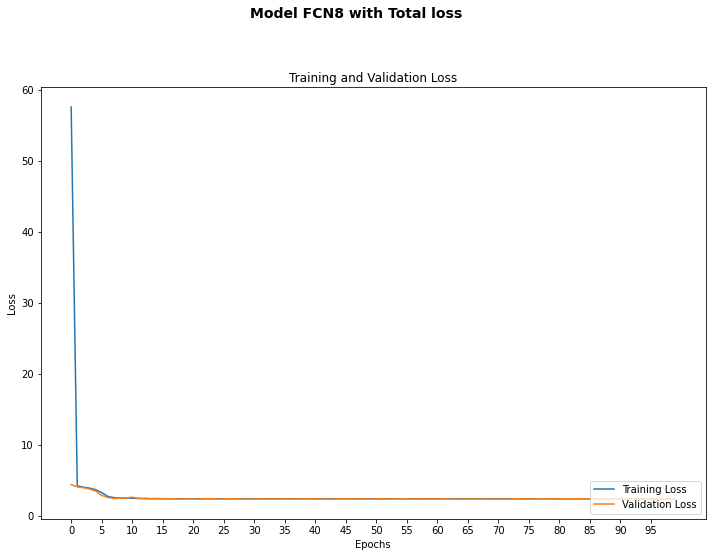

In [44]:
# Loss
base_loss = base_history_fcn8_total.history['loss']
base_val_loss = base_history_fcn8_total.history['val_loss']

# Give a title
title = 'Model FCN8 with Total loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_fcn8_total, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [45]:
# Evaluate the model with Test set
results_total = model_fcn8_total.evaluate(test_gen, batch_size=batch_size)
performances['FCN8 Total loss'] = [results_total[1], results_total[2], stop-start]
performances.head()

2/2 [==============================] - 7s 3s/step - loss: 2.3937 - io_u_3: 0.8752 - dice_coef: 0.8813


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss,U-net Augmented Total loss,U-net Augmented Balanced loss,VGG-16 Augmented Dice loss,VGG-16 Augmented Total loss,VGG-16 Augmented Balanced loss,FCN8 Dice loss,FCN8 Total loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985,0.763196,0.944746,0.745015,0.813090,0.950786,0.929387,0.875164
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430,0.962638,0.906425,0.452401,0.961118,0.917195,0.743814,0.881341
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259,25642.705065,28087.876644,74760.303561,73406.170201,74565.478434,26066.356232,24958.430808


#### c. Balanced cross entropy<a class="anchor" id="IV3c"></a>

In [46]:
model_fcn8_balanced = segmentation_model()
model_fcn8_balanced.compile(
    optimizer="rmsprop", 
    loss=balanced_cross_entropy(0.3), 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_balanced_fcn8 = model_fcn8_balanced.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size
)
stop = time()

Epoch 1/100
16/16 [==============================] - 242s 15s/step - loss: 0.4871 - io_u_4: 0.8289 - dice_coef: 0.2262 - val_loss: 0.4882 - val_io_u_4: 0.8047 - val_dice_coef: 0.2426
Epoch 2/100
16/16 [==============================] - 244s 15s/step - loss: 0.4865 - io_u_4: 0.8104 - dice_coef: 0.2669 - val_loss: 0.4884 - val_io_u_4: 0.8040 - val_dice_coef: 0.2396
Epoch 3/100
16/16 [==============================] - 258s 16s/step - loss: 0.4865 - io_u_4: 0.8104 - dice_coef: 0.2670 - val_loss: 0.4862 - val_io_u_4: 0.8114 - val_dice_coef: 0.2712
Epoch 4/100
16/16 [==============================] - 258s 16s/step - loss: 0.4869 - io_u_4: 0.8092 - dice_coef: 0.2619 - val_loss: 0.4868 - val_io_u_4: 0.8095 - val_dice_coef: 0.2631
Epoch 5/100
16/16 [==============================] - 259s 16s/step - loss: 0.4878 - io_u_4: 0.8061 - dice_coef: 0.2486 - val_loss: 0.4808 - val_io_u_4: 0.8303 - val_dice_coef: 0.3509
Epoch 6/100
16/16 [==============================] - 258s 16s/step - loss: 0.4809 - i

16/16 [==============================] - 242s 15s/step - loss: 0.4770 - io_u_4: 0.8435 - dice_coef: 0.4057 - val_loss: 0.4767 - val_io_u_4: 0.8445 - val_dice_coef: 0.4098
Epoch 90/100
16/16 [==============================] - 237s 15s/step - loss: 0.4771 - io_u_4: 0.8432 - dice_coef: 0.4047 - val_loss: 0.4766 - val_io_u_4: 0.8449 - val_dice_coef: 0.4114
Epoch 91/100
16/16 [==============================] - 240s 15s/step - loss: 0.4771 - io_u_4: 0.8432 - dice_coef: 0.4044 - val_loss: 0.4765 - val_io_u_4: 0.8452 - val_dice_coef: 0.4127
Epoch 92/100
16/16 [==============================] - 245s 15s/step - loss: 0.4770 - io_u_4: 0.8435 - dice_coef: 0.4059 - val_loss: 0.4768 - val_io_u_4: 0.8443 - val_dice_coef: 0.4091
Epoch 93/100
16/16 [==============================] - 238s 15s/step - loss: 0.4771 - io_u_4: 0.8431 - dice_coef: 0.4041 - val_loss: 0.4769 - val_io_u_4: 0.8440 - val_dice_coef: 0.4078
Epoch 94/100
16/16 [==============================] - 237s 15s/step - loss: 0.4770 - io_u_4: 

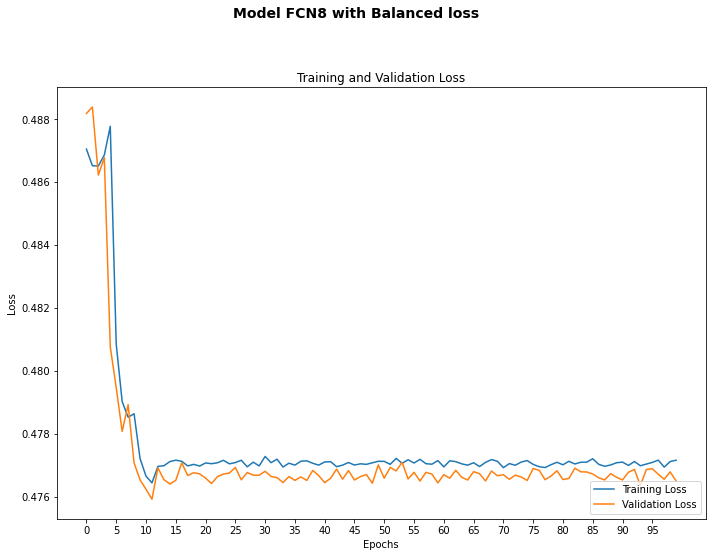

In [47]:
# Loss
base_loss = base_history_balanced_fcn8.history['loss']
base_val_loss = base_history_balanced_fcn8.history['val_loss']

# Give a title
title = 'Model FCN8 with Balanced loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_fcn8_balanced, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [48]:
# Evaluate the model with Test set
results_balanced = model_fcn8_balanced.evaluate(test_gen, batch_size=batch_size)
performances['FCN8 Balanced loss'] = [results_balanced[1], results_balanced[2], stop-start]
performances.head()

2/2 [==============================] - 7s 3s/step - loss: 0.4773 - io_u_4: 0.8426 - dice_coef: 0.4020


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss,U-net Augmented Total loss,U-net Augmented Balanced loss,VGG-16 Augmented Dice loss,VGG-16 Augmented Total loss,VGG-16 Augmented Balanced loss,FCN8 Dice loss,FCN8 Total loss,FCN8 Balanced loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985,0.763196,0.944746,0.745015,0.813090,0.950786,0.929387,0.875164,0.842584
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430,0.962638,0.906425,0.452401,0.961118,0.917195,0.743814,0.881341,0.401985
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259,25642.705065,28087.876644,74760.303561,73406.170201,74565.478434,26066.356232,24958.430808,24707.132534


### 4. Augmentation de données<a class="anchor" id="IV4"></a>

Le principe d'**augmentation de données** repose sur le principe d’augmenter de façon artificielle nos donnée, en y appliquant des transformations. On va pouvoir augmenter la diversité et donc le champ d’apprentissage de notre modèle, qui va pouvoir mieux s’adapter pour prédire de nouvelles données. En partant d’une simple image, nous pouvons la dupliquer autant de fois que nous avons des types de transformation différentes à lui appliquer. Et nous pouvons en augmenter davantage en croisant ces effets sur une même image, et en y appliquant différents valeurs de l’effet dans une fourchette donnée, pour avoir un résultat plus ou moins poussé.

In [49]:
train_gen = seg_gen(
    train_input_dir,
    train_target_dir,
    32,
    128,
    256,
    categories,
    sample_perc=20,
    aug_blur=True,
    aug_zoom=True,
    aug_brightness=True,
    aug_flip=True,
)

val_gen = seg_gen(
    val_input_dir,
    val_target_dir,
    32,
    128,
    256,
    categories,
    sample_perc=20,
    aug_blur=True,
    aug_zoom=True,
    aug_brightness=True,
    aug_flip=True,
)

test_gen = seg_gen(
    test_input_dir,
    test_target_dir,
    32,
    128,
    256,
    categories,
    sample_perc=10,
    aug_blur=True,
    aug_zoom=True,
    aug_brightness=True,
    aug_flip=True,
)

### 5. U-net avec données augmentées<a class="anchor" id="IV5"></a>

#### a. Dice loss<a class="anchor" id="IV5a"></a>

In [13]:
model_unet_dice_aug = unet(8)
model_unet_dice_aug.compile(
    optimizer="rmsprop", 
    loss=dice_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_dice_aug = model_unet_dice_aug.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size,
)
stop = time()

Epoch 1/100
16/16 [==============================] - 331s 20s/step - loss: 0.7331 - io_u_1: 0.9293 - dice_coef: 0.8574 - val_loss: 0.7273 - val_io_u_1: 0.7619 - val_dice_coef: 0.9228
Epoch 2/100
16/16 [==============================] - 311s 19s/step - loss: 0.7280 - io_u_1: 0.9498 - dice_coef: 0.9154 - val_loss: 0.7262 - val_io_u_1: 0.9537 - val_dice_coef: 0.9358
Epoch 3/100
16/16 [==============================] - 300s 19s/step - loss: 0.7285 - io_u_1: 0.9461 - dice_coef: 0.9089 - val_loss: 0.7262 - val_io_u_1: 0.9565 - val_dice_coef: 0.9350
Epoch 4/100
16/16 [==============================] - 300s 19s/step - loss: 0.7279 - io_u_1: 0.9503 - dice_coef: 0.9163 - val_loss: 0.7275 - val_io_u_1: 0.9490 - val_dice_coef: 0.9202
Epoch 5/100
16/16 [==============================] - 253s 16s/step - loss: 0.7285 - io_u_1: 0.9466 - dice_coef: 0.9097 - val_loss: 0.7278 - val_io_u_1: 0.9475 - val_dice_coef: 0.9173
Epoch 6/100
16/16 [==============================] - 249s 15s/step - loss: 0.7284 - i

16/16 [==============================] - 257s 16s/step - loss: 0.7284 - io_u_1: 0.9473 - dice_coef: 0.9110 - val_loss: 0.7288 - val_io_u_1: 0.9442 - val_dice_coef: 0.9054
Epoch 90/100
16/16 [==============================] - 256s 16s/step - loss: 0.7282 - io_u_1: 0.9484 - dice_coef: 0.9129 - val_loss: 0.7273 - val_io_u_1: 0.9539 - val_dice_coef: 0.9227
Epoch 91/100
16/16 [==============================] - 256s 16s/step - loss: 0.7286 - io_u_1: 0.9457 - dice_coef: 0.9082 - val_loss: 0.7271 - val_io_u_1: 0.9551 - val_dice_coef: 0.9247
Epoch 92/100
16/16 [==============================] - 257s 16s/step - loss: 0.7283 - io_u_1: 0.9478 - dice_coef: 0.9118 - val_loss: 0.7274 - val_io_u_1: 0.9532 - val_dice_coef: 0.9214
Epoch 93/100
16/16 [==============================] - 256s 16s/step - loss: 0.7277 - io_u_1: 0.9514 - dice_coef: 0.9183 - val_loss: 0.7266 - val_io_u_1: 0.9588 - val_dice_coef: 0.9313
Epoch 94/100
16/16 [==============================] - 258s 16s/step - loss: 0.7286 - io_u_1: 

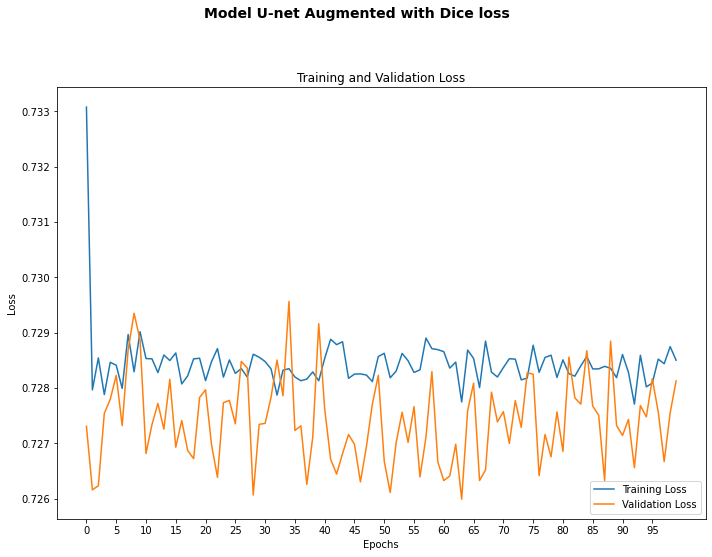

In [14]:
# Give a title
title = 'Model U-net Augmented with Dice loss'

# Loss
base_loss = base_history_dice_aug.history['loss']
base_val_loss = base_history_dice_aug.history['val_loss']
    
# Call function to plot learning curves
std_learning_curves(
    model_unet_dice_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [23]:
# Evaluate the model with Test set
results_dice = model_unet_dice_aug.evaluate(test_gen, batch_size=batch_size)

performances['U-net Augmented Dice loss'] = [results_dice[1], results_dice[2], stop-start]
performances.head()

2/2 [==============================] - 13s 5s/step - loss: 0.7284 - io_u_1: 0.9470 - dice_coef: 0.9104


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259


#### b. Total loss<a class="anchor" id="IV5b"></a>

In [24]:
model_unet_total_aug = unet(8)
model_unet_total_aug.compile(
    optimizer="rmsprop", 
    loss=total_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_total_aug = model_unet_total_aug.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size)
stop = time()

Epoch 1/100
16/16 [==============================] - 267s 16s/step - loss: 4.2743 - io_u_2: 0.7824 - dice_coef: 0.7975 - val_loss: 3.0958 - val_io_u_2: 0.7619 - val_dice_coef: 0.8980
Epoch 2/100
16/16 [==============================] - 258s 16s/step - loss: 2.5253 - io_u_2: 0.7649 - dice_coef: 0.8724 - val_loss: 2.8343 - val_io_u_2: 0.7619 - val_dice_coef: 0.9216
Epoch 3/100
16/16 [==============================] - 257s 16s/step - loss: 2.5486 - io_u_2: 0.7643 - dice_coef: 0.8641 - val_loss: 2.6663 - val_io_u_2: 0.7619 - val_dice_coef: 0.9086
Epoch 4/100
16/16 [==============================] - 256s 16s/step - loss: 2.4465 - io_u_2: 0.7629 - dice_coef: 0.8860 - val_loss: 2.7587 - val_io_u_2: 0.7619 - val_dice_coef: 0.8955
Epoch 5/100
16/16 [==============================] - 258s 16s/step - loss: 2.5384 - io_u_2: 0.7644 - dice_coef: 0.8614 - val_loss: 2.6525 - val_io_u_2: 0.7619 - val_dice_coef: 0.9154
Epoch 6/100
16/16 [==============================] - 257s 16s/step - loss: 2.3971 - i

16/16 [==============================] - 258s 16s/step - loss: 2.2095 - io_u_2: 0.7636 - dice_coef: 0.9763 - val_loss: 2.2735 - val_io_u_2: 0.7633 - val_dice_coef: 0.9681
Epoch 90/100
16/16 [==============================] - 258s 16s/step - loss: 2.2102 - io_u_2: 0.7628 - dice_coef: 0.9763 - val_loss: 2.3013 - val_io_u_2: 0.7621 - val_dice_coef: 0.9525
Epoch 91/100
16/16 [==============================] - 256s 16s/step - loss: 2.2060 - io_u_2: 0.7628 - dice_coef: 0.9781 - val_loss: 2.2546 - val_io_u_2: 0.7620 - val_dice_coef: 0.9623
Epoch 92/100
16/16 [==============================] - 257s 16s/step - loss: 2.2111 - io_u_2: 0.7626 - dice_coef: 0.9757 - val_loss: 2.2748 - val_io_u_2: 0.7629 - val_dice_coef: 0.9619
Epoch 93/100
16/16 [==============================] - 256s 16s/step - loss: 2.2083 - io_u_2: 0.7628 - dice_coef: 0.9772 - val_loss: 2.2547 - val_io_u_2: 0.7625 - val_dice_coef: 0.9672
Epoch 94/100
16/16 [==============================] - 256s 16s/step - loss: 2.2446 - io_u_2: 

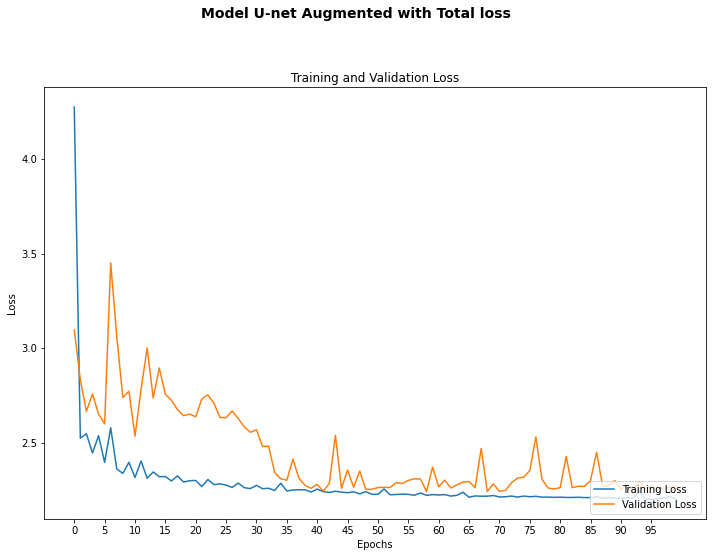

In [25]:
# Loss
base_loss = base_history_total_aug.history['loss']
base_val_loss = base_history_total_aug.history['val_loss']

# Give a title
title = 'Model U-net Augmented with Total loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_unet_total_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [26]:
# Evaluate the model with Test set
results_total = model_unet_total_aug.evaluate(test_gen, batch_size=batch_size)
performances['U-net Augmented Total loss'] = [results_total[1], results_total[2], stop-start]
performances.head()

2/2 [==============================] - 14s 5s/step - loss: 2.2567 - io_u_2: 0.7632 - dice_coef: 0.9626


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss,U-net Augmented Total loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985,0.763196
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430,0.962638
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259,25642.705065


#### c. Balanced cross entropy<a class="anchor" id="IV5c"></a>

In [29]:
model_unet_balanced_aug = unet(8)
model_unet_balanced_aug.compile(
    optimizer="rmsprop", 
    loss=balanced_cross_entropy(0.3), 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_balanced_aug = model_unet_balanced_aug.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size)
stop = time()

Epoch 1/100
16/16 [==============================] - 281s 17s/step - loss: 0.4466 - io_u_4: 0.9269 - dice_coef: 0.8467 - val_loss: 0.4420 - val_io_u_4: 0.7619 - val_dice_coef: 0.9165
Epoch 2/100
16/16 [==============================] - 283s 18s/step - loss: 0.4422 - io_u_4: 0.9487 - dice_coef: 0.9135 - val_loss: 0.4420 - val_io_u_4: 0.9415 - val_dice_coef: 0.9162
Epoch 3/100
16/16 [==============================] - 281s 17s/step - loss: 0.4422 - io_u_4: 0.9486 - dice_coef: 0.9133 - val_loss: 0.4415 - val_io_u_4: 0.9506 - val_dice_coef: 0.9234
Epoch 4/100
16/16 [==============================] - 281s 18s/step - loss: 0.4422 - io_u_4: 0.9491 - dice_coef: 0.9142 - val_loss: 0.4418 - val_io_u_4: 0.9489 - val_dice_coef: 0.9197
Epoch 5/100
16/16 [==============================] - 281s 18s/step - loss: 0.4425 - io_u_4: 0.9466 - dice_coef: 0.9097 - val_loss: 0.4422 - val_io_u_4: 0.9454 - val_dice_coef: 0.9132
Epoch 6/100
16/16 [==============================] - 280s 17s/step - loss: 0.4427 - i

16/16 [==============================] - 283s 18s/step - loss: 0.4424 - io_u_4: 0.9472 - dice_coef: 0.9109 - val_loss: 0.4417 - val_io_u_4: 0.9531 - val_dice_coef: 0.9212
Epoch 90/100
16/16 [==============================] - 284s 18s/step - loss: 0.4426 - io_u_4: 0.9456 - dice_coef: 0.9080 - val_loss: 0.4414 - val_io_u_4: 0.9553 - val_dice_coef: 0.9251
Epoch 91/100
16/16 [==============================] - 283s 18s/step - loss: 0.4423 - io_u_4: 0.9479 - dice_coef: 0.9121 - val_loss: 0.4413 - val_io_u_4: 0.9567 - val_dice_coef: 0.9275
Epoch 92/100
16/16 [==============================] - 283s 18s/step - loss: 0.4424 - io_u_4: 0.9472 - dice_coef: 0.9108 - val_loss: 0.4415 - val_io_u_4: 0.9549 - val_dice_coef: 0.9244
Epoch 93/100
16/16 [==============================] - 283s 18s/step - loss: 0.4423 - io_u_4: 0.9481 - dice_coef: 0.9124 - val_loss: 0.4416 - val_io_u_4: 0.9539 - val_dice_coef: 0.9226
Epoch 94/100
16/16 [==============================] - 285s 18s/step - loss: 0.4426 - io_u_4: 

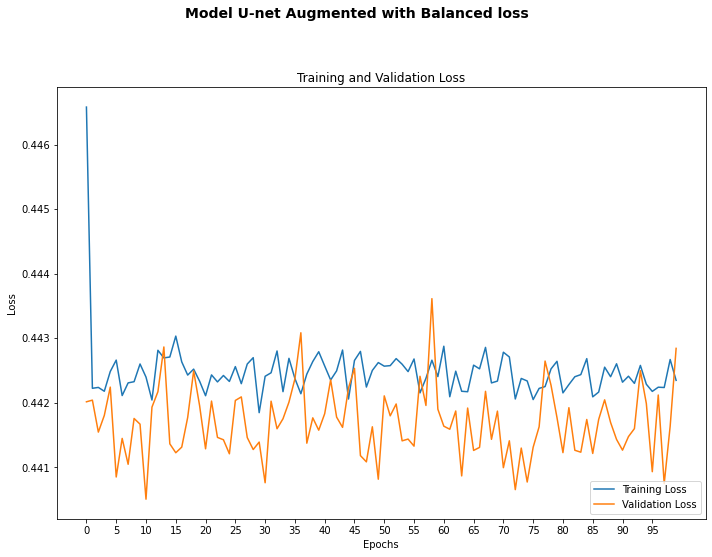

In [30]:
# Loss
base_loss = base_history_balanced_aug.history['loss']
base_val_loss = base_history_balanced_aug.history['val_loss']

# Give a title
title = 'Model U-net Augmented with Balanced loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_unet_balanced_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [31]:
# Evaluate the model with Test set
results_balanced = model_unet_balanced_aug.evaluate(test_gen, batch_size=batch_size)
performances['U-net Augmented Balanced loss'] = [results_balanced[1], results_balanced[2], stop-start]
performances.head()

2/2 [==============================] - 14s 6s/step - loss: 0.4427 - io_u_4: 0.9447 - dice_coef: 0.9064


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss,U-net Augmented Total loss,U-net Augmented Balanced loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985,0.763196,0.944746
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430,0.962638,0.906425
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259,25642.705065,28087.876644


### 6. VGG-16 avec données augmentées<a class="anchor" id="IV6"></a>

#### a. Dice loss<a class="anchor" id="IV6a"></a>

In [32]:
model_vgg_dice_aug = fcn()
model_vgg_dice_aug.compile(
    optimizer="rmsprop", 
    loss=dice_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_dice_vgg_aug = model_vgg_dice_aug.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    batch_size=batch_size
)
stop = time()

Epoch 1/100
16/16 [==============================] - 801s 50s/step - loss: 0.7819 - io_u_5: 0.7073 - dice_coef: 0.3048 - val_loss: 0.7709 - val_io_u_5: 0.7415 - val_dice_coef: 0.4298
Epoch 2/100
16/16 [==============================] - 785s 49s/step - loss: 0.7693 - io_u_5: 0.7438 - dice_coef: 0.4474 - val_loss: 0.7684 - val_io_u_5: 0.7468 - val_dice_coef: 0.4574
Epoch 3/100
16/16 [==============================] - 771s 48s/step - loss: 0.7689 - io_u_5: 0.7451 - dice_coef: 0.4525 - val_loss: 0.7682 - val_io_u_5: 0.7478 - val_dice_coef: 0.4603
Epoch 4/100
16/16 [==============================] - 766s 48s/step - loss: 0.7688 - io_u_5: 0.7453 - dice_coef: 0.4531 - val_loss: 0.7686 - val_io_u_5: 0.7462 - val_dice_coef: 0.4558
Epoch 5/100
16/16 [==============================] - 762s 48s/step - loss: 0.7687 - io_u_5: 0.7456 - dice_coef: 0.4539 - val_loss: 0.7682 - val_io_u_5: 0.7478 - val_dice_coef: 0.4603
Epoch 6/100
16/16 [==============================] - 767s 48s/step - loss: 0.7686 - i

16/16 [==============================] - 736s 46s/step - loss: 0.7689 - io_u_5: 0.7448 - dice_coef: 0.4517 - val_loss: 0.7681 - val_io_u_5: 0.7480 - val_dice_coef: 0.4611
Epoch 90/100
16/16 [==============================] - 712s 45s/step - loss: 0.7688 - io_u_5: 0.7452 - dice_coef: 0.4529 - val_loss: 0.7686 - val_io_u_5: 0.7460 - val_dice_coef: 0.4553
Epoch 91/100
16/16 [==============================] - 712s 45s/step - loss: 0.7688 - io_u_5: 0.7455 - dice_coef: 0.4537 - val_loss: 0.7682 - val_io_u_5: 0.7478 - val_dice_coef: 0.4605
Epoch 92/100
16/16 [==============================] - 717s 45s/step - loss: 0.7685 - io_u_5: 0.7463 - dice_coef: 0.4562 - val_loss: 0.7684 - val_io_u_5: 0.7468 - val_dice_coef: 0.4577
Epoch 93/100
16/16 [==============================] - 728s 46s/step - loss: 0.7689 - io_u_5: 0.7450 - dice_coef: 0.4524 - val_loss: 0.7682 - val_io_u_5: 0.7477 - val_dice_coef: 0.4601
Epoch 94/100
16/16 [==============================] - 719s 45s/step - loss: 0.7689 - io_u_5: 

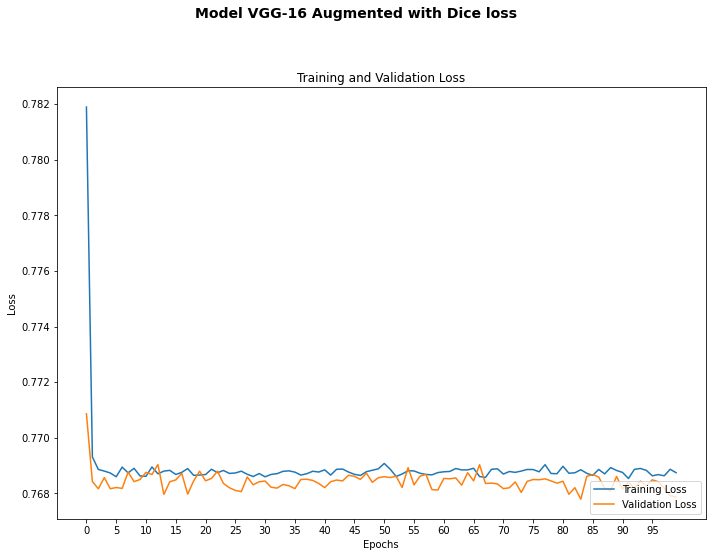

In [33]:
# Loss
base_loss = base_history_dice_vgg_aug.history['loss']
base_val_loss = base_history_dice_vgg_aug.history['val_loss']

# Give a title
title = 'Model VGG-16 Augmented with Dice loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_vgg_dice_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [34]:
# Evaluate the model with Test set
results_dice = model_vgg_dice_aug.evaluate(test_gen, batch_size=batch_size)
performances['VGG-16 Augmented Dice loss'] = [results_dice[1], results_dice[2], stop-start]
performances.head()

2/2 [==============================] - 24s 11s/step - loss: 0.7689 - io_u_5: 0.7450 - dice_coef: 0.4524


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss,U-net Augmented Total loss,U-net Augmented Balanced loss,VGG-16 Augmented Dice loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985,0.763196,0.944746,0.745015
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430,0.962638,0.906425,0.452401
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259,25642.705065,28087.876644,74760.303561


#### b. Total loss<a class="anchor" id="IV6b"></a>

In [35]:
model_vgg_total_aug = fcn()
model_vgg_total_aug.compile(
    optimizer="rmsprop", 
    loss=total_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
) 
start = time()
base_history_total_vgg_aug = model_vgg_total_aug.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    batch_size=batch_size
)
stop = time()

Epoch 1/100
16/16 [==============================] - 671s 42s/step - loss: 15192.5732 - io_u_6: 0.7539 - dice_coef: 0.1353 - val_loss: 4.3575 - val_io_u_6: 0.7619 - val_dice_coef: 0.1470
Epoch 2/100
16/16 [==============================] - 671s 42s/step - loss: 4.3329 - io_u_6: 0.7619 - dice_coef: 0.1549 - val_loss: 4.2645 - val_io_u_6: 0.7619 - val_dice_coef: 0.1639
Epoch 3/100
16/16 [==============================] - 664s 42s/step - loss: 4.2269 - io_u_6: 0.7619 - dice_coef: 0.1724 - val_loss: 4.1776 - val_io_u_6: 0.7619 - val_dice_coef: 0.1802
Epoch 4/100
16/16 [==============================] - 672s 42s/step - loss: 4.1533 - io_u_6: 0.7619 - dice_coef: 0.1858 - val_loss: 4.1175 - val_io_u_6: 0.7619 - val_dice_coef: 0.1870
Epoch 5/100
16/16 [==============================] - 669s 42s/step - loss: 4.0783 - io_u_6: 0.7619 - dice_coef: 0.2019 - val_loss: 4.0188 - val_io_u_6: 0.7619 - val_dice_coef: 0.2158
Epoch 6/100
16/16 [==============================] - 673s 42s/step - loss: 3.9952

16/16 [==============================] - 988s 62s/step - loss: 2.2255 - io_u_6: 0.8196 - dice_coef: 0.9689 - val_loss: 2.2615 - val_io_u_6: 0.8299 - val_dice_coef: 0.9654
Epoch 90/100
16/16 [==============================] - 977s 61s/step - loss: 2.2993 - io_u_6: 0.8062 - dice_coef: 0.9443 - val_loss: 2.2685 - val_io_u_6: 0.8146 - val_dice_coef: 0.9543
Epoch 91/100
16/16 [==============================] - 997s 62s/step - loss: 2.2249 - io_u_6: 0.8217 - dice_coef: 0.9684 - val_loss: 2.2420 - val_io_u_6: 0.8255 - val_dice_coef: 0.9674
Epoch 92/100
16/16 [==============================] - 753s 46s/step - loss: 2.2304 - io_u_6: 0.8171 - dice_coef: 0.9668 - val_loss: 2.2452 - val_io_u_6: 0.8138 - val_dice_coef: 0.9643
Epoch 93/100
16/16 [==============================] - 672s 42s/step - loss: 2.2398 - io_u_6: 0.8120 - dice_coef: 0.9629 - val_loss: 2.2657 - val_io_u_6: 0.8105 - val_dice_coef: 0.9506
Epoch 94/100
16/16 [==============================] - 672s 42s/step - loss: 2.2226 - io_u_6: 

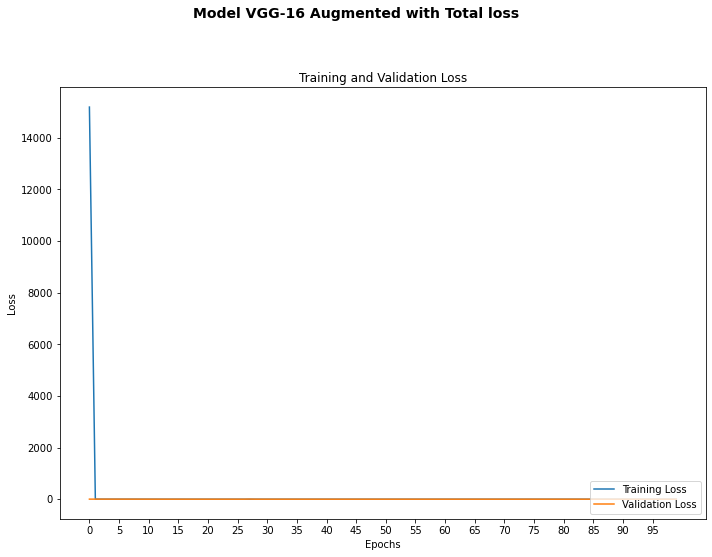

In [36]:
# Loss
base_loss = base_history_total_vgg_aug.history['loss']
base_val_loss = base_history_total_vgg_aug.history['val_loss']

# Give a title
title = 'Model VGG-16 Augmented with Total loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_vgg_total_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [37]:
# Evaluate the model with Test set
results_total = model_vgg_total_aug.evaluate(test_gen, batch_size=batch_size)
performances['VGG-16 Augmented Total loss'] = [results_total[1], results_total[2], stop-start]
performances.head()

2/2 [==============================] - 21s 9s/step - loss: 2.2583 - io_u_6: 0.8131 - dice_coef: 0.9611


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss,U-net Augmented Total loss,U-net Augmented Balanced loss,VGG-16 Augmented Dice loss,VGG-16 Augmented Total loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985,0.763196,0.944746,0.745015,0.813090
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430,0.962638,0.906425,0.452401,0.961118
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259,25642.705065,28087.876644,74760.303561,73406.170201


#### c. Balanced cross entropy<a class="anchor" id="IV6c"></a>

In [38]:
model_vgg_balanced_aug = fcn()
model_vgg_balanced_aug.compile(
    optimizer="rmsprop", 
    loss=balanced_cross_entropy(0.3), 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_balanced_vgg_aug = model_vgg_balanced_aug.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size
)
stop = time()

Epoch 1/100
16/16 [==============================] - 725s 45s/step - loss: 0.4885 - io_u_7: 0.6886 - dice_coef: 0.2309 - val_loss: 0.4809 - val_io_u_7: 0.7195 - val_dice_coef: 0.3487
Epoch 2/100
16/16 [==============================] - 742s 46s/step - loss: 0.4772 - io_u_7: 0.7508 - dice_coef: 0.3965 - val_loss: 0.4702 - val_io_u_7: 0.7789 - val_dice_coef: 0.4974
Epoch 3/100
16/16 [==============================] - 739s 46s/step - loss: 0.4683 - io_u_7: 0.7746 - dice_coef: 0.5151 - val_loss: 0.4649 - val_io_u_7: 0.7748 - val_dice_coef: 0.5635
Epoch 4/100
16/16 [==============================] - 739s 46s/step - loss: 0.4642 - io_u_7: 0.7777 - dice_coef: 0.5729 - val_loss: 0.4617 - val_io_u_7: 0.7679 - val_dice_coef: 0.6063
Epoch 5/100
16/16 [==============================] - 736s 46s/step - loss: 0.4592 - io_u_7: 0.7801 - dice_coef: 0.6473 - val_loss: 0.4574 - val_io_u_7: 0.7801 - val_dice_coef: 0.6726
Epoch 6/100
16/16 [==============================] - 741s 46s/step - loss: 0.4578 - i

16/16 [==============================] - 741s 46s/step - loss: 0.4424 - io_u_7: 0.9469 - dice_coef: 0.9102 - val_loss: 0.4421 - val_io_u_7: 0.9500 - val_dice_coef: 0.9157
Epoch 90/100
16/16 [==============================] - 743s 46s/step - loss: 0.4427 - io_u_7: 0.9448 - dice_coef: 0.9066 - val_loss: 0.4412 - val_io_u_7: 0.9568 - val_dice_coef: 0.9278
Epoch 91/100
16/16 [==============================] - 801s 50s/step - loss: 0.4425 - io_u_7: 0.9461 - dice_coef: 0.9088 - val_loss: 0.4421 - val_io_u_7: 0.9499 - val_dice_coef: 0.9155
Epoch 92/100
16/16 [==============================] - 799s 50s/step - loss: 0.4421 - io_u_7: 0.9496 - dice_coef: 0.9151 - val_loss: 0.4414 - val_io_u_7: 0.9558 - val_dice_coef: 0.9260
Epoch 93/100
16/16 [==============================] - 881s 55s/step - loss: 0.4427 - io_u_7: 0.9452 - dice_coef: 0.9072 - val_loss: 0.4413 - val_io_u_7: 0.9567 - val_dice_coef: 0.9276
Epoch 94/100
16/16 [==============================] - 904s 57s/step - loss: 0.4428 - io_u_7: 

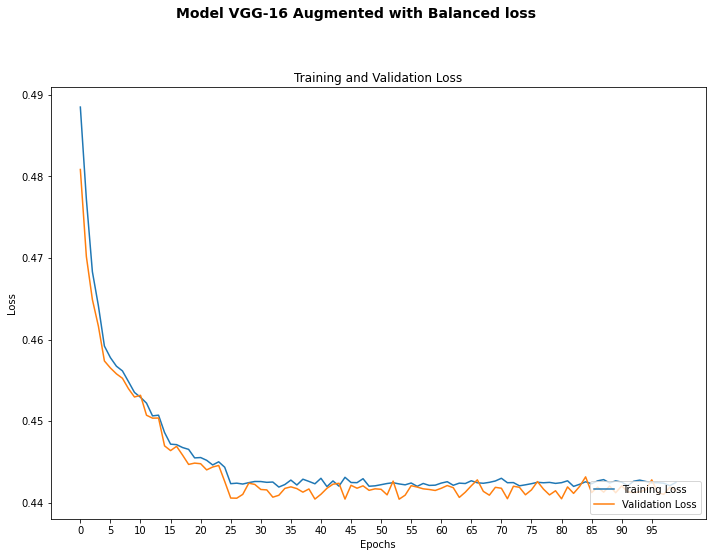

In [39]:
# Loss
base_loss = base_history_balanced_vgg_aug.history['loss']
base_val_loss = base_history_balanced_vgg_aug.history['val_loss']

# Give a title
title = 'Model VGG-16 Augmented with Balanced loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_vgg_balanced_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [40]:
# Evaluate the model with Test set
results_balanced = model_vgg_balanced_aug.evaluate(test_gen, batch_size=batch_size)
performances['VGG-16 Augmented Balanced loss'] = [results_balanced[1], results_balanced[2], stop-start]
performances.head()

2/2 [==============================] - 25s 11s/step - loss: 0.4420 - io_u_7: 0.9508 - dice_coef: 0.9172


,U-net Dice loss,U-net Total loss,U-net Balanced loss,VGG-16 Dice loss,VGG-16 Total loss,VGG-16 Balanced loss,U-net Augmented Dice loss,U-net Augmented Total loss,U-net Augmented Balanced loss,VGG-16 Augmented Dice loss,VGG-16 Augmented Total loss,VGG-16 Augmented Balanced loss
IoU,0.977563,0.887825,0.980365,0.860144,0.934942,0.990926,0.946985,0.763196,0.944746,0.745015,0.813090,0.950786
Dice coefficient,0.920600,0.963801,0.930598,0.473710,0.973045,0.971707,0.910430,0.962638,0.906425,0.452401,0.961118,0.917195
Training time,6224.462833,6494.797175,6495.223846,13741.885128,14259.938646,14977.959314,26592.311259,25642.705065,28087.876644,74760.303561,73406.170201,74565.478434


### 7. Modèle FCN8 avec données augmentées<a class="anchor" id="IV7"></a>

#### a. Dice loss<a class="anchor" id="IV7a"></a>

In [ ]:
model_fcn8_dice_aug = segmentation_model()
model_fcn8_dice_aug.compile(
    optimizer="rmsprop", 
    loss=dice_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_fcn8_dice_aug = model_fcn8_dice_aug.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size
)
stop = time()

Epoch 1/100
16/16 [==============================] - 1241s 77s/step - loss: 0.7867 - io_u_5: 0.7009 - dice_coef: 0.2504 - val_loss: 0.7708 - val_io_u_5: 0.7390 - val_dice_coef: 0.4300
Epoch 2/100
11/16 [===================>..........] - ETA: 6:21 - loss: 0.7578 - io_u_5: 0.7941 - dice_coef: 0.5775

In [ ]:
# Loss
base_loss = base_history_fcn8_dice_aug.history['loss']
base_val_loss = base_history_fcn8_dice_aug.history['val_loss']

# Give a title
title = 'Model FCN8 Augmented with Dice loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_fcn8_dice_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [ ]:
# Evaluate the model with Test set
results_dice = model_fcn8_dice_aug.evaluate(test_gen, batch_size=batch_size)
performances['FCN8 Augmented Dice loss'] = [results_dice[1], results_dice[2], stop-start]
performances.head()

#### b. Total loss<a class="anchor" id="IV7b"></a>

In [ ]:
model_fcn8_total_aug = segmentation_model()
model_fcn8_total_aug.compile(
    optimizer="rmsprop", 
    loss=total_loss, 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
) 
start = time()
base_history_total_fcn8_aug = model_fcn8_total_aug.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size
)
stop = time()

In [ ]:
# Loss
base_loss = base_history_total_fcn8_aug.history['loss']
base_val_loss = base_history_total_fcn8_aug.history['val_loss']

# Give a title
title = 'Model FCN8 Augmented with Total loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_fcn8_total_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [ ]:
# Evaluate the model with Test set
results_total = model_fcn8_total_aug.evaluate(test_gen, batch_size=batch_size)
performances['FCN8 Augmented Total loss'] = [results_total[1], results_total[2], stop-start]
performances.head()

#### c. Balanced cross entropy<a class="anchor" id="IV7c"></a>

In [ ]:
model_fcn8_balanced_aug = segmentation_model()
model_fcn8_balanced_aug.compile(
    optimizer="rmsprop", 
    loss=balanced_cross_entropy(0.3), 
    metrics=[
        IoU(num_classes=8, target_class_ids=[0]),
        dice_coef
    ]
)
start = time()
base_history_balanced_fcn8_aug = model_fcn8_balanced_aug.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=epochs, 
    batch_size=batch_size
)
stop = time()

In [ ]:
# Loss
base_loss = base_history_balanced_fcn8_aug.history['loss']
base_val_loss = base_history_balanced_fcn8_aug.history['val_loss']

# Give a title
title = 'Model FCN8 Augmented with Balanced loss'
    
# Call function to plot learning curves
std_learning_curves(
    model_fcn8_balanced_aug, 
    title,
    epochs, 
    base_loss, 
    base_val_loss
)

In [ ]:
# Evaluate the model with Test set
results_balanced = model_fcn8_balanced_aug.evaluate(test_gen, batch_size=batch_size)
performances['Custom Balanced loss'] = [results_balanced[1], results_balanced[2], stop-start]
performances.head()

### 8. Choix du modèle<a class="anchor" id="IV8"></a>

Au vu des performances des différents modèles et du temps d'entraînement de chacun, nous allons utiliser le modèle U-net avec la fonction de perte balanced cross entropy pour modèle de segmentation d'iamges.

In [ ]:
model_unet_balanced.save('model/model.h5')